# MODELING AND EXECUTION (WITH TUNING)

**To help differentiate where are the differences in this notebook as compared to the "un-tune" model notebook. We will be using green color font to highlight the markdown cells explaining the difference.**

<font color=green>This notebook is an almost exact replica of the "02_Modeling_Execution_without_Tuning" notebook. The key difference is under the `Modeling and validation - LSTM` section, the modeling had been modified to include a Tensorflow Keras Tuner process to dynamically tune the model and its hyperparameter using RandomSearch to find the optimal model. As such we will not be repeated explaining the same contents but we will illustrate the additional codes added to this notebook for the purpose of tuning.

Another important difference is the directories save paths are made different so as not to overwrite the "un-tune" modeling results.

**It is also strongly recommended that you read the IMPORTANT VARIABLES SETTINGS section before attempting to run this notebook.**</font>

# Importing packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import datetime
import time

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam

from keras.callbacks import EarlyStopping
from keras import backend
from keras.models import model_from_json
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

# setting some parameters
pd.options.display.max_columns = 50
pd.options.display.max_rows = 100

# fix random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# enable interactive toolbar
#%matplotlib widget

# to return to normal if interactive maps are not working
#%matplotlib inline

In [2]:
# checking versions
print('tensorflow version =', tf.__version__) # version 2.2 works with GPU, version 2.3 may have issues
print('pandas version =', pd.__version__) # version 1.2.0 and below work
print('numpy version =', np.__version__) # version 1.19.5 and below work
print('keras version = ', keras.__version__) # version 2.3.0-tf works with GPU, other version may have issues

tensorflow version = 2.3.0
pandas version = 1.2.0
numpy version = 1.18.5
keras version =  2.4.0


In [3]:
# test to confirm GPU is available
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print('This version of Tensorflow or Keras is not working with GPUs. Expect slower speed.')

1 Physical GPUs, 1 Logical GPUs


# Data import and pre-processing

We shall import the data files from the data collection and EDA stage for pre-processing.

## Prices data

In [4]:
# reading in prices retrieved from yfinance
price_data = pd.read_csv('datasets/backups/cleaned_daily_adj_prices_df.csv')
print(price_data.shape)
price_data.head()

(154687, 12)


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker,name,sector,industry
0,2013-01-02,24.597448,24.935559,24.019845,24.738327,13767900.0,0.0,0.0,ABBV,AbbVie Inc.,Healthcare,Drug Manufacturers - General
1,2013-01-03,24.653801,24.653801,24.062110,24.534056,16739300.0,0.0,0.0,ABBV,AbbVie Inc.,Healthcare,Drug Manufacturers - General
2,2013-01-04,24.386131,24.576318,24.125506,24.224121,21372100.0,0.0,0.0,ABBV,AbbVie Inc.,Healthcare,Drug Manufacturers - General
3,2013-01-07,24.055067,24.970780,24.055067,24.273428,17897100.0,0.0,0.0,ABBV,AbbVie Inc.,Healthcare,Drug Manufacturers - General
4,2013-01-08,24.153686,24.400223,23.498599,23.745136,17863300.0,0.0,0.0,ABBV,AbbVie Inc.,Healthcare,Drug Manufacturers - General


In [5]:
# set Date to datetime
price_data['Date'] = pd.to_datetime(price_data['Date'])

In [6]:
print(len(price_data.ticker.unique()))
price_data.ticker.unique()

20


array(['ABBV', 'CAG', 'CSCO', 'GSK', 'LMT', 'MRK', 'RCI', 'TRP', 'VALE',
       'VZ', 'ABT', 'AJG', 'DG', 'FBHS', 'FMC', 'LDOS', 'MGA', 'NEM',
       'PWR', 'SAP'], dtype=object)

## News data

In [7]:
# reading in news sentiment
senti_mean_df = pd.read_csv('datasets/backups/news_senti.csv')
print(senti_mean_df.shape)
senti_mean_df.head()

(1088, 4)


,ticker,date,compound,Interpretation
0,ABBV,2020-11-24,0.18060,Positive
1,ABBV,2020-11-25,0.33260,Positive
2,ABBV,2020-11-27,0.12755,Positive
3,ABBV,2020-11-28,0.62490,Positive
4,ABBV,2020-11-29,0.00000,Neutral


In [8]:
# set Date to datetime
senti_mean_df['date'] = pd.to_datetime(senti_mean_df['date'])

In [9]:
senti_mean_df.ticker.unique()

array(['ABBV', 'CAG', 'CSCO', 'GSK', 'LMT', 'MRK', 'RCI', 'TRP', 'VALE',
       'VZ', 'ABT', 'AJG', 'DG', 'FBHS', 'FMC', 'LDOS', 'MGA', 'NEM',
       'PWR', 'SAP'], dtype=object)

## Analyst's recommendations data

In [10]:
# read analyst recom data
analyst_recom_df = pd.read_csv('datasets/backups/cleaned_complete_scrape_analyst_recom.csv')
print(analyst_recom_df.shape)
analyst_recom_df.head()

(400, 5)


,date,recom_type,source,ticker,recom_type_ordinal
0,2020-11-10,Resumed,Bernstein,ABBV,4
1,2020-09-29,Initiated,Berenberg,ABBV,2
2,2020-06-23,Upgrade,Atlantic Equities,ABBV,5
3,2020-06-09,Upgrade,Wolfe Research,ABBV,5
4,2020-06-02,Upgrade,Argus,ABBV,5


In [11]:
# convert datetime
analyst_recom_df['date'] = analyst_recom_df['date'].astype('datetime64')
analyst_recom_df.dtypes

date                  datetime64[ns]
recom_type                    object
source                        object
ticker                        object
recom_type_ordinal             int64
dtype: object

In [12]:
# sort and reset index
analyst_recom_df.sort_values(by='date', inplace=True)
analyst_recom_df.reset_index(drop=True, inplace=True)
analyst_recom_df.head()

,date,recom_type,source,ticker,recom_type_ordinal
0,2015-10-23,Reiterated,Barclays,RCI,3
1,2015-12-04,Initiated,Goldman,RCI,2
2,2015-12-11,Upgrade,TD Securities,RCI,5
3,2015-12-17,Downgrade,Morgan Stanley,RCI,1
4,2016-04-19,Reiterated,RBC Capital Mkts,RCI,3


## Introducing Technical Indicators

The following technical indicators are added to the data set and there are many more that could be added if the use has clear understanding of how those indicators work. Having more will increase the complexity of the model and computationally expensive for the scope of this project.

**Momentum indicators**

1. **SMA20** - A simple moving average (SMA) calculates the average of a selected range of prices, usually closing prices, by the number of periods in that range. In this case, we are using the 20 periods moving average.

2. **RSI14** - The relative strength index (RSI) is a momentum indicator used in technical analysis that measures the magnitude of recent price changes to evaluate overbought or oversold conditions in the price of a stock or other asset. 

3. **MOM5** - The Momentum indicator is a measurement of the acceleration and deceleration of prices. It indicates if prices are increasing at an increasing rate or decreasing at a decreasing rate. The Momentum function can be applied to the price, or to any other data series. In this case, we are using the 5 periods momentum.

**Volume indicators**

1. **OBV** - On-balance volume (OBV), a momentum indicator that measures positive and negative volume flow.

**Volatility indicators**

1. **ATR14** - Average true range (ATR) is a market volatility indicator used in technical analysis. It is typically derived from the 14-day simple moving average of a series of true range indicators.

In [13]:
import talib as ta

In [14]:
# adding technical indicators to the price dataframe

# momentum indicators
price_data['SMA20'] = ta.SMA(price_data['Close'], timeperiod=20)
price_data['RSI14'] = ta.RSI(price_data['Close'], timeperiod=14)
price_data['MOM5'] = ta.MOM(price_data['Close'], timeperiod=5)

# volume indicators
price_data['OBV'] = ta.OBV(price_data['Close'], price_data['Volume'])

# volatility indicators
price_data['ATR14'] = ta.ATR(price_data['High'], price_data['Low'],
                             price_data['Close'], timeperiod=14)

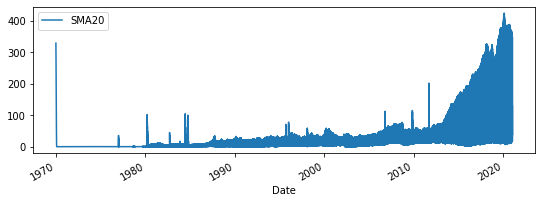

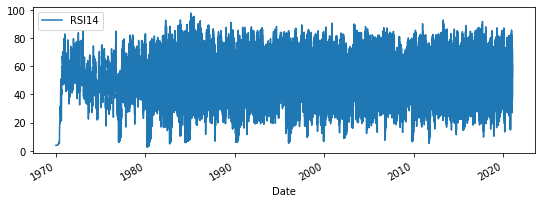

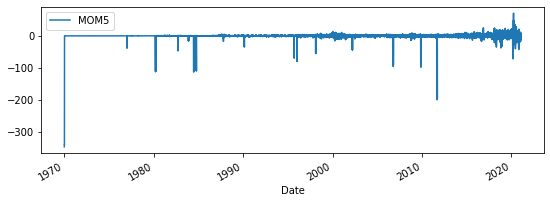

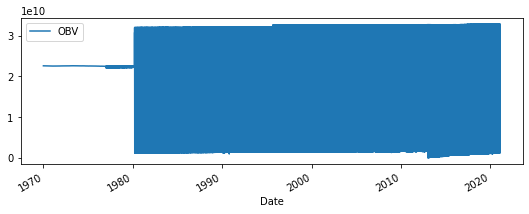

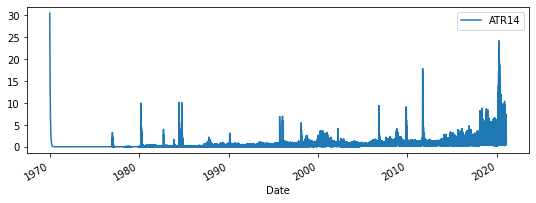

In [15]:
# plot the technical indicators to confirm they are calculated
price_data.plot('Date', 'SMA20', kind='line', figsize=(9,3));
price_data.plot('Date', 'RSI14', kind='line', figsize=(9,3));
price_data.plot('Date', 'MOM5', kind='line', figsize=(9,3));
price_data.plot('Date', 'OBV', kind='line', figsize=(9,3));
price_data.plot('Date', 'ATR14', kind='line', figsize=(9,3));

## Merge the data

In [16]:
# view shape of price data
print(price_data.shape)
price_data.columns

(154687, 17)


Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends',
       'Stock Splits', 'ticker', 'name', 'sector', 'industry', 'SMA20',
       'RSI14', 'MOM5', 'OBV', 'ATR14'],
      dtype='object')

In [17]:
# view shape of analyst data
print(analyst_recom_df.shape)
analyst_recom_df.columns

(400, 5)


Index(['date', 'recom_type', 'source', 'ticker', 'recom_type_ordinal'], dtype='object')

In [18]:
# view shape of sentiment data
print(senti_mean_df.shape)
senti_mean_df.columns

(1088, 4)


Index(['ticker', 'date', 'compound', 'Interpretation'], dtype='object')

In [19]:
# merge price and analyst data
price_ana_df = pd.merge(price_data, analyst_recom_df, how='left', left_on=['Date', 'ticker'], right_on=['date', 'ticker'])
print(price_ana_df.shape)
price_ana_df.head()

(154704, 21)


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker,name,sector,industry,SMA20,RSI14,MOM5,OBV,ATR14,date,recom_type,source,recom_type_ordinal
0,2013-01-02,24.597448,24.935559,24.019845,24.738327,13767900.0,0.0,0.0,ABBV,AbbVie Inc.,Healthcare,Drug Manufacturers - General,NaN,NaN,NaN,13767900.0,NaN,NaT,NaN,NaN,NaN
1,2013-01-03,24.653801,24.653801,24.062110,24.534056,16739300.0,0.0,0.0,ABBV,AbbVie Inc.,Healthcare,Drug Manufacturers - General,NaN,NaN,NaN,-2971400.0,NaN,NaT,NaN,NaN,NaN
2,2013-01-04,24.386131,24.576318,24.125506,24.224121,21372100.0,0.0,0.0,ABBV,AbbVie Inc.,Healthcare,Drug Manufacturers - General,NaN,NaN,NaN,-24343500.0,NaN,NaT,NaN,NaN,NaN
3,2013-01-07,24.055067,24.970780,24.055067,24.273428,17897100.0,0.0,0.0,ABBV,AbbVie Inc.,Healthcare,Drug Manufacturers - General,NaN,NaN,NaN,-6446400.0,NaN,NaT,NaN,NaN,NaN
4,2013-01-08,24.153686,24.400223,23.498599,23.745136,17863300.0,0.0,0.0,ABBV,AbbVie Inc.,Healthcare,Drug Manufacturers - General,NaN,NaN,NaN,-24309700.0,NaN,NaT,NaN,NaN,NaN


In [20]:
# merge price, analyst and sentiment data
price_ana_senti_df = pd.merge(price_ana_df, senti_mean_df, how='left', left_on=['Date', 'ticker'], right_on=['date', 'ticker'])
print(price_ana_senti_df.shape)
price_ana_senti_df.head()

(154704, 24)


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker,name,sector,industry,SMA20,RSI14,MOM5,OBV,ATR14,date_x,recom_type,source,recom_type_ordinal,date_y,compound,Interpretation
0,2013-01-02,24.597448,24.935559,24.019845,24.738327,13767900.0,0.0,0.0,ABBV,AbbVie Inc.,Healthcare,Drug Manufacturers - General,NaN,NaN,NaN,13767900.0,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN
1,2013-01-03,24.653801,24.653801,24.062110,24.534056,16739300.0,0.0,0.0,ABBV,AbbVie Inc.,Healthcare,Drug Manufacturers - General,NaN,NaN,NaN,-2971400.0,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN
2,2013-01-04,24.386131,24.576318,24.125506,24.224121,21372100.0,0.0,0.0,ABBV,AbbVie Inc.,Healthcare,Drug Manufacturers - General,NaN,NaN,NaN,-24343500.0,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN
3,2013-01-07,24.055067,24.970780,24.055067,24.273428,17897100.0,0.0,0.0,ABBV,AbbVie Inc.,Healthcare,Drug Manufacturers - General,NaN,NaN,NaN,-6446400.0,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN
4,2013-01-08,24.153686,24.400223,23.498599,23.745136,17863300.0,0.0,0.0,ABBV,AbbVie Inc.,Healthcare,Drug Manufacturers - General,NaN,NaN,NaN,-24309700.0,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN


In [21]:
# view shape of fully merged data
print(price_ana_senti_df.shape)
price_ana_senti_df.sort_index(inplace=True)
price_ana_senti_df.columns

(154704, 24)


Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends',
       'Stock Splits', 'ticker', 'name', 'sector', 'industry', 'SMA20',
       'RSI14', 'MOM5', 'OBV', 'ATR14', 'date_x', 'recom_type', 'source',
       'recom_type_ordinal', 'date_y', 'compound', 'Interpretation'],
      dtype='object')

In [22]:
# checking NaN
price_ana_senti_df.isnull().sum()

Date                       0
Open                       0
High                       0
Low                        0
Close                      0
Volume                     0
Dividends                  0
Stock Splits               0
ticker                     0
name                       0
sector                     0
industry                   0
SMA20                     19
RSI14                     14
MOM5                       5
OBV                        0
ATR14                     14
date_x                154304
recom_type            154304
source                154304
recom_type_ordinal    154304
date_y                153741
compound              153741
Interpretation        153741
dtype: int64

**Note:** NaN values for `SMA20` `RSI14` `MOM5` `ATR14` are due to rolling calculations from past periods. These NaN are at the beginning of the data range for each company and will be imputed with zero before being pass into the modeling stage.

`date_x` `recom_type` `source` `date_y` `Interpretation` NaN values do not need to be treated as these are not features that are to be used in modeling.

`recom_type_ordinal` `compound` NaN values mean that there is no analyst recommendation and no news article sentiments respectively on those dates. These features will be used in modeling therefore they will be imputed with zero before being fed into modeling stage.

# Modeling preparation

Here we are training, debugging, evaluating and executing the model for one company in the portfolio. As the number of steps/cells to complete the cycle for one company is too long and complex, we will not be writing a loop through all the steps from here to end of the transactions audit steps. The steps below are meant for explaining the steps and logic behind.

This time consuming process only need to be ran once for the selected company as there is a step to save the trained model. As long as there is no change in data size and data structure, we can easily load the saved model to test a different strategy. However, if the data and/or parameters change then the whole training cycle will have to be re-run.

## IMPORTANT VARIABLES SETTINGS

Key variables used throughout the code shall be defined here.

<font color=green>Note the different directory save paths here aw well. This is done to avoid over writing of the "un-tune" model results.</font>

**NOTE: THE EXPLANATION OF VISUALIZATION, EVALUATION, EXECUTION AND AUDITING PROCESSES ARE ALL BASED ON COMPANY "CSCO". IF YOU CHANGE THE COMPANY BELOW TO SOMETHING ELSE TO TEST THE CODES, THE EXPLANATION WILL NOT TALLY. BUT YOU CAN ALWAYS CHANGE BACK TO "CSCO" AND RE-RUN TO GET BACK THE VISUALIZATION TO MATCH THE EXPLANATION. IT WILL ONLY TAKE SOME TIME TO RE-RUN.**

In [28]:
# setting working directories
IMAGE_DIR = 'images/with_keras_tuning/'
TRANS_DIR = 'results/transactions/with_keras_tuning/'
PERF_DIR = 'results/performance/with_keras_tuning/'

# setting account starting balance and pred_pct_gain in daily prices before making a trade
acct_start_bal = 50000
pred_pct_gain = 1.05

# setting commission and fees (based on DBS OET US market fees)
comm_rate = 0.0015 # 0.15% on trans_amount each time but a min. of $18 will be imposed in the buy/sell functions
min_fees = 18

# setting the company to run
test_comp = 'CSCO'
one_comp_df = price_ana_senti_df[price_ana_senti_df['ticker'] == test_comp]

In [29]:
# keeping only the necessary columns
lstm_data = one_comp_df[['Date', 'Open', 'High', 'Low', 'Volume', 'Close',
                         'SMA20', 'RSI14', 'MOM5', 'OBV', 'ATR14',
                         'recom_type_ordinal', 'compound']]

# make all nan as zero
lstm_data = lstm_data.fillna(0)

# set data as the index
lstm_data.set_index('Date', drop=True, inplace=True)

# setting and partitioning train data boundary
lstm_data = lstm_data.loc['2000-01-01':'2021-01-05']
print('No of trading days available for training data =', lstm_data.shape[0])

No of trading days available for training data = 5286


In [30]:
# setting the number of periods to look back as train data
n_per_in  = 60
print(f'{n_per_in} periods look back for training')

# setting the number of periods in future to predict
n_per_out = 1
print(f'{n_per_out} period(s) prediction')

# setting the number of features
n_features = lstm_data.shape[1]
print(f'{n_features} features to train on')

# calculating number of sequences to train
print(f'Number of training sequences = {lstm_data.shape[0] / n_per_in}')

60 periods look back for training
1 period(s) prediction
12 features to train on
Number of training sequences = 88.1


## Scaling data

**StandardScaler** removes the mean and scales the data to unit variance. However, the outliers have an influence when computing the empirical mean and standard deviation. Note in particular that because the outliers on each feature have different magnitudes, the spread of the transformed data on each feature is very different: most of the data lie in the [-2, 4] range for the transformed median income feature while the same data is squeezed in the smaller [-0.2, 0.2] range for the transformed number of households. StandardScaler therefore cannot guarantee balanced feature scales in the presence of outliers.

**MinMaxScaler** rescales the data set such that all feature values are in the range [0, 1]. However, this scaling compresses all inliers into the narrow range [0, 0.005] for the transformed number of households. Both StandardScaler and MinMaxScaler are very sensitive to the presence of outliers.

**RobustScaler** is based on percentiles and are therefore not influenced by a few number of very large marginal outliers. Consequently, the resulting range of the transformed feature values is larger than for the previous scalers and, more importantly, are approximately similar: for both features most of the transformed values lie in a [-2, 3] range. Note that the outliers themselves are still present in the transformed data. If a separate outlier clipping is desirable, a non-linear transformation is required.

**Decision** was to test all three scalers as majority of the literature research online could not conclude which scaler is the best for our project application context. Almost all literatures suggested to test all three and use the one with the best performance. In our context, we tested all three scalers and found that **MinMaxScaler** performed the best.

In [31]:
# Close Price Scaling, meant for inverse scaling CLose price at the end
close_sc = MinMaxScaler(feature_range=(0, 1))
close_sc.fit(lstm_data[['Close']])

MinMaxScaler()

In [32]:
# Feature Scaling
sc = MinMaxScaler(feature_range=(0, 1))
lstm_data_scaled = pd.DataFrame(sc.fit_transform(lstm_data), columns=lstm_data.columns, index=lstm_data.index)
lstm_data_scaled.tail()

,Open,High,Low,Volume,Close,SMA20,RSI14,MOM5,OBV,ATR14,recom_type_ordinal,compound
Date,,,,,,,,,,,,
2020-12-29,0.701491,0.698056,0.718137,0.019506,0.708237,0.778704,0.638291,0.569508,0.832943,0.150188,0.0,0.646332
2020-12-30,0.697311,0.694594,0.716455,0.018100,0.705267,0.779699,0.606674,0.570795,0.831215,0.148213,0.0,0.395722
2020-12-31,0.690769,0.690585,0.711219,0.025360,0.710279,0.780610,0.642222,0.595662,0.833578,0.147592,0.0,0.336515
2021-01-04,0.696028,0.688577,0.702648,0.041976,0.702232,0.780829,0.557442,0.570216,0.829762,0.154460,0.0,1.000000
2021-01-05,0.684485,0.683066,0.703213,0.030120,0.702607,0.780783,0.560448,0.554789,0.832541,0.153707,0.0,0.336515


In [33]:
# checking ordinal scale
lstm_data_scaled.recom_type_ordinal.unique()

array([0. , 0.6, 0.4, 0.2, 0.8, 1. ])

In [34]:
# checking compound scale
# if the result is 0, that means no news analyzed in the data period for this company
lstm_data_scaled.compound.unique()

array([0.33651537, 0.44700376, 0.45587239, 0.58021802, 0.44851266,
       0.70862844, 0.51828129, 0.        , 0.83155755, 0.64633245,
       0.39572171, 1.        ])

## Helper functions

In [35]:
# function to split the data set into no. of periods to step back and no. of periods in future to predict
def split_sequence(seq, n_steps_in, n_steps_out):
    X, y = [], []
    
    for i in range(len(seq)):
        # find end of current sequence
        end = i + n_steps_in
        out_end = end + n_steps_out
        
        # break if exceed dataset length
        if out_end > len(seq):
            break
        
        # splitting the sequences into: x = past prices and features, y = prices ahead
        seq_x, seq_y = seq[i:end, :], seq[end:out_end, 0]
        
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)

In [36]:
# function to plot the loss and accuracy for the training and testing data
def visualize_training_results(results):
    history = results.history
    plt.figure(figsize=(10,6))
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'train_loss'])
    plt.title(test_comp+' - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.savefig(IMAGE_DIR+test_comp+'_loss.png', facecolor='w', edgecolor='w',
                dpi=200, transparent=False, bbox_inches=None, pad_inches=0.1)
    plt.show()

In [37]:
# function to add hidden layers and dropout rates if necessary
def layer_maker(n_layers, n_nodes, activation, drop=None, d_rate=.5):
    """
    Creates a specified number of hidden layers for an RNN
    Optional: Adds regularization option - the dropout layer to prevent potential overfitting (if necessary)
    """
    
    # Creating the specified number of hidden layers with the specified number of nodes
    for x in range(1,n_layers+1):
        lstm_model.add(LSTM(n_nodes, activation=activation, return_sequences=True))

        # Adds a Dropout layer after every Nth hidden layer (the 'drop' variable)
        try:
            if x % drop == 0:
                lstm_model.add(Dropout(d_rate))
        except:
            pass

In [38]:
# function to get predictions
def validater(n_per_in, n_per_out):
    """
    Runs a 'For' loop to iterate through the length of the DF and create predicted values for every stated interval
    Returns a DF containing the predicted values for the model with the corresponding index values based on a business
    day frequency
    """
    
    # Creating an empty DF to store the predictions
    predictions = pd.DataFrame(index=lstm_data_scaled.index, columns=[lstm_data.columns[4]])
    predictions.Close.astype('float')

    for i in range(n_per_in, len(lstm_data_scaled)-n_per_in, n_per_out):
        # Creating rolling intervals to predict off of actual sequence values
        x = lstm_data_scaled[-i - n_per_in:-i]
        #print(x)

        # Predicting using rolling intervals
        yhat = best_model.predict(np.array(x).reshape(1, n_per_in, n_features))
        #print('preditions yhat', yhat)

        # Transforming values back to their normal prices
        yhat = close_sc.inverse_transform(yhat)[0]
        #print('inversed yhat', yhat)

        # DF to store the values and append later, frequency uses business days
        pred_df = pd.DataFrame(yhat, 
                               index=pd.date_range(start=x.index[-1], 
                                                   periods=len(yhat),
                                                   freq='B'),
                               columns=[x.columns[4]])
        #print('pred_df', pred_df)

        # Updating the predictions DF
        predictions.update(pred_df)
        #print('predictions', predictions)

        
    # add one cycle for last sequence????
    
    return predictions

In [39]:
def val_rmse(df1, df2):
    """
    Calculates the root mean square error between the two Dataframes
    """
    df = df1.copy()
    
    # Adding a new column with the closing prices from the second DF
    df['close2'] = df2.Close
    
    # Dropping the NaN values
    df.dropna(inplace=True)
    
    # Adding another column containing the difference between the two DFs' closing prices
    df['diff'] = df.Close - df.close2
    
    # Squaring the difference and getting the mean
    mse = (df[['diff']]**2).mean()
    
    # Returning the square root of the mean square error
    return float(np.sqrt(mse))

## Split and re-shape data

In [40]:
# Splitting the data into appropriate sequences
X, y = split_sequence(lstm_data_scaled.to_numpy(), n_per_in, n_per_out)
print(X.shape)
print(y.shape)

(5226, 60, 12)
(5226, 1)


# Modeling and validation - LSTM (tuned)

**NOTE - If there is no change in data and there is a saved model, there is no need to re-train the model. We can go to the "Loading saved model from disk" section to load the saved model and continue from there."**

We will be building a simple LSTM model that takes the input of 60 periods step back to predict 1 period in the future. <font color=green>This will be a "tuned" model.</font> Each company in our portfolios will go through the "un-tune" and "tuned" models in order for us to compare which portfolio (domain knowledge vs unsupervised Kmeans) is more superior. As such, the "un-tune" models' collective portfolio performance shall serve as our baseline.

Over here we are dynamically building the LSTM model using a custom function and Tensorflow Keras RandomSearch Tuner. The number of layers, number of nodes in each layer will be randomly selected within a range of values that we specified. For each company, we are performing 3 trials with random permutations of hyperparameters. In each trial, we will train the model twice due to the stochastic nature of gradient descent. The best hyperparameters with the lowest val_loss in these trials will be returned as the best model of the trials.

<font color=green>**Note**: If you are interested to refresh on the LSTM choice please refer to the modeling without tuning notebook.</font>

In [151]:
# keras tuner

def build_model(hp):
    
    # instantiation
    lstm_model = Sequential()

    # set activation
    activ = 'tanh'

    # adding the input and first LSTM layer
    lstm_model.add(LSTM(units=hp.Int("input_units", min_value=64, max_value=256, step=32),
                        activation=activ, return_sequences=True,
                        input_shape=(n_per_in, n_features)))

    # hidden layers with Dropout regularisation
    for i in range(hp.Int("n_layers", 1, 2)):
        lstm_model.add(LSTM(units=hp.Int(f"hidden_{i}_units", min_value=64, max_value=256, step=32),
                            activation=activ, return_sequences=True))
        lstm_model.add(Dropout(0.2))

    # final hidden layer w/o return_sequences
    lstm_model.add(LSTM(units=hp.Int("final_units", min_value=64, max_value=256, step=32),
                        activation=activ))

    # output layer
    lstm_model.add(Dense(n_per_out))

    # Compiling the RNN
    lstm_model.compile(optimizer=Adam(lr=0.01), loss='mse')
       
    return lstm_model

In [152]:
# setting the directory to store the search results
LOG_DIR = f'keras_tuner_logs/{test_comp}_{int(time.time())}'

In [153]:
'''The max_trials variable represents the number of hyperparameter combinations that will 
be tested by the tuner, while the execution_per_trial variable is the number of models that should
be built and fit for each trial for robustness purposes.
'''
#initializing randomsearch
tuner = RandomSearch(build_model,
                     objective = 'val_loss',
                     max_trials = 3,   # how many random permutations do you want
                     executions_per_trial = 2, # how many time to train for each permutations
                     directory = LOG_DIR,
                     project_name = 'SEEDED(42) RandomSearch')

In [154]:
# implementing early stop
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, mode='auto')
# min_delta=0 mean stop whenever the val_loss increases but patience=5 means wait 5 epochs before deciding
# mode='auto' mean depending on the monitor, it will decide to use min/max. e.g accuracy use max, loss use min

In [155]:
# fitting the model and starting the randomsearch
tuner.search(X, y, epochs=30, batch_size=64, validation_split=0.1, callbacks=[early_stop])

Trial 3 Complete [00h 00m 40s]
val_loss: 0.00032069699955172837

Best val_loss So Far: 0.00032069699955172837
Total elapsed time: 00h 01m 48s
INFO:tensorflow:Oracle triggered exit


In [156]:
# display the search space summary
# this is made reproducible using SEED=42. If purely searching for the ultimate best and without resource constraints,
# the SEED can be a hypersearch parameter too.
tuner.search_space_summary()

Search space summary
Default search space size: 5
input_units (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 32, 'sampling': None}
n_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 2, 'step': 1, 'sampling': None}
hidden_0_units (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 32, 'sampling': None}
final_units (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 32, 'sampling': None}
hidden_1_units (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 32, 'sampling': None}


In [157]:
# display the search results and params of each trial
tuner.results_summary()

Results summary
Results in keras_tuner_logs/RCI_1611507447\SEEDED(42) RandomSearch
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
input_units: 160
n_layers: 1
hidden_0_units: 160
final_units: 64
hidden_1_units: 160
Score: 0.00032069699955172837
Trial summary
Hyperparameters:
input_units: 192
n_layers: 2
hidden_0_units: 64
final_units: 224
hidden_1_units: 64
Score: 0.0032147193560376763
Trial summary
Hyperparameters:
input_units: 128
n_layers: 1
hidden_0_units: 160
final_units: 128
hidden_1_units: 192
Score: 0.17871791124343872


In [158]:
# store the best_params for re-instating later
best_params = tuner.get_best_hyperparameters()[0]

# display the best params values
tuner.get_best_hyperparameters()[0].values

{'input_units': 160,
 'n_layers': 1,
 'hidden_0_units': 160,
 'final_units': 64,
 'hidden_1_units': 160}

In [159]:
# display the best model summary for replication, note that this step actually load the best model that was
# saved in the LOG DIR. However, this is only a shortcut and it is highly recommended to re-create the best
# model using the best params then fit and re-train the data set
tuner.get_best_models()[0].summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 160)           110720    
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 160)           205440    
_________________________________________________________________
dropout (Dropout)            (None, 60, 160)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                57600     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 373,825
Trainable params: 373,825
Non-trainable params: 0
_________________________________________________________________


In [160]:
# Re-build the best model with the optimal hyperparameters
best_model = tuner.hypermodel.build(best_params)

# re-train on the data set for randomsearch
results = best_model.fit(X, y, epochs=30, batch_size=32, validation_split=0.1, callbacks=[early_stop])

Epoch 1/30
147/147 [==============================] - 2s 16ms/step - loss: 0.0933 - val_loss: 0.0020
Epoch 2/30
147/147 [==============================] - 1s 10ms/step - loss: 5.1718e-04 - val_loss: 6.6213e-04
Epoch 3/30
147/147 [==============================] - 1s 9ms/step - loss: 4.0571e-04 - val_loss: 0.0013
Epoch 4/30
147/147 [==============================] - 2s 11ms/step - loss: 3.9782e-04 - val_loss: 4.1071e-04
Epoch 5/30
147/147 [==============================] - 2s 11ms/step - loss: 2.2150e-04 - val_loss: 3.8303e-04
Epoch 6/30
147/147 [==============================] - 2s 13ms/step - loss: 2.1626e-04 - val_loss: 6.6789e-04
Epoch 7/30
147/147 [==============================] - 1s 10ms/step - loss: 1.9536e-04 - val_loss: 6.5463e-04
Epoch 8/30
147/147 [==============================] - 1s 9ms/step - loss: 1.9246e-04 - val_loss: 2.4901e-04
Epoch 9/30
147/147 [==============================] - 1s 9ms/step - loss: 1.9587e-04 - val_loss: 2.7154e-04
Epoch 10/30
147/147 [=============

In [161]:
# display the re-trained best model summary for cross checking that it is indeed re-training based on the best params
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 160)           110720    
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 160)           205440    
_________________________________________________________________
dropout (Dropout)            (None, 60, 160)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                57600     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 373,825
Trainable params: 373,825
Non-trainable params: 0
_________________________________________________________________


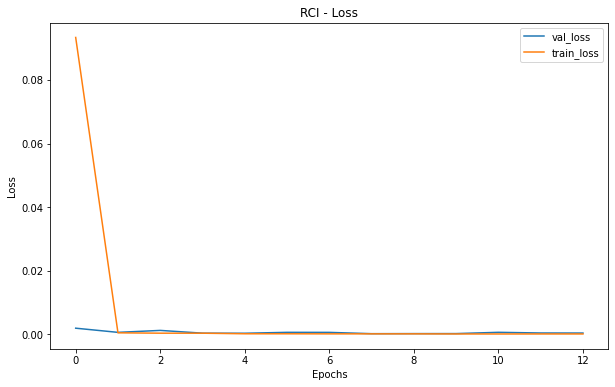

In [162]:
# visulizing training results
visualize_training_results(results)

## Exporting trained model to disk

This step should always be executed after a new model has been train with new data in order to save the model and trained weights to disk. When we open this notebook in the future and as long as data sets have no changes. We can skip the model training section to save time and just load the previous model and weights from disk to continue with the predictions and evaluation codes. This allow us to adjust our trading strategies without have to re-run the LSTM model training.

This will allow us to re-use this notebook for different companies to record and save the results to an external file for total portfolio evaluation later.

In [163]:
# serialize model to JSON
filepath = 'saved_models/with_keras_tuning/'+test_comp
best_model_json = best_model.to_json()
with open(filepath+'_best_model.json', 'w') as json_file:
    json_file.write(best_model_json)

In [164]:
# serialize weights to HDF5
best_model.save_weights(filepath+'_best_model.h5')
print('Saved model to disk')

Saved model to disk


## Loading saved model from disk

**NOTE - If we have a saved model and there are no data changes, we can run this section to load the saved model and weights without having to re-run the training epochs.**

**STEPS:**
1. Clear notebook kernel.
2. Go to section "IMPORTANT VARIABLES SETTINGS", update the `test_comp` variable with the company ticker.
2. Run from beginning of notebook and stop just before MODELING AND VALIDATION.
3. Continue running from "LOADING SAVED MODEL" till the end of the notebook to generate all the the plots and result csv files.

In [41]:
# load json and create model
filepath = 'saved_models/with_keras_tuning/'+test_comp
json_file = open(filepath+'_best_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
best_model = model_from_json(loaded_model_json)

In [42]:
# load weights into new model
best_model.load_weights(filepath+'_best_model.h5')
print('Loaded model from disk')

Loaded model from disk


In [43]:
# Transforming the actual values to their original price
actual = pd.DataFrame(close_sc.inverse_transform(lstm_data_scaled[["Close"]]), 
                      index=lstm_data.index, 
                      columns=[lstm_data.columns[4]])
actual.tail()

,Close
Date,
2020-12-29,44.280884
2020-12-30,44.122169
2020-12-31,44.389999
2021-01-04,43.959999
2021-01-05,43.980000


In [44]:
# Getting a DF of the predicted values to validate against
print('WARNING: This PREDICTION step takes a while to run due to looping every single period in the dataset')
predictions = validater(n_per_in, n_per_out)

In [45]:
# Printing the RMSE
rmse = val_rmse(actual, predictions)
print('RMSE:', rmse )

RMSE: 1.1086438876028906


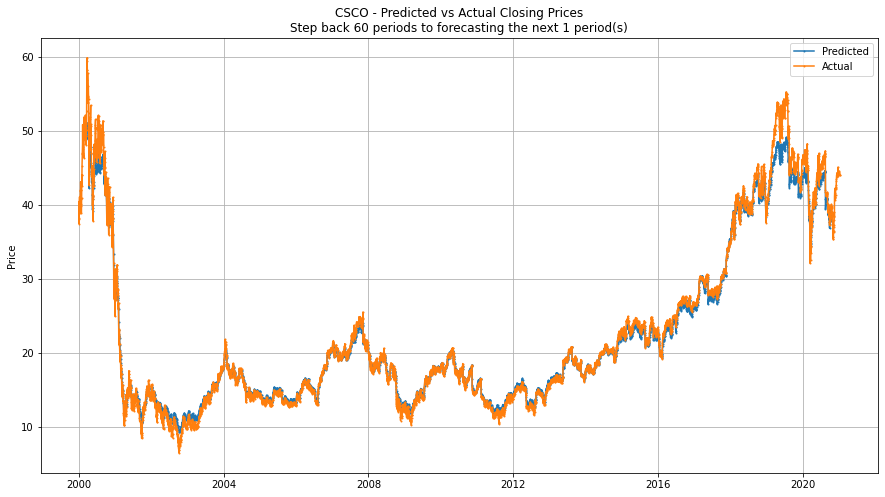

In [46]:
# plotting the actual and predicted prices of the last test sequence
plt.figure(figsize=(15,8), facecolor='white')

# Printing and plotting those predictions
plt.plot(predictions, label='Predicted', marker='o', markersize=1)

# Printing and plotting the actual values
plt.plot(actual, label='Actual', marker='o', markersize=1)

plt.title(f'{test_comp} - Predicted vs Actual Closing Prices\nStep back {n_per_in} periods to forecasting the next {n_per_out} period(s)')
plt.ylabel('Price')
plt.legend()

# restricting x-axis to view
# left = datetime.datetime(2000,1,1)
# right = datetime.datetime(2020,12,30)
#plt.xlim(left, right)
#plt.xlim(data_start, data_end)

plt.grid()
plt.savefig(IMAGE_DIR+test_comp+'pred_vs_actual_all_seq.png', facecolor='w', edgecolor='w',
            dpi=200, transparent=False, bbox_inches=None, pad_inches=0.1)
plt.show()

<font color=green>**Note:** This is the first visualization of how the LSTM model had learned the price trend from the sequences of 60 periods data. It is not expected that the predictions (blue) will match perfectly to the actual prices (orange). In this CSCO example, it certainly look like the "tuned" LSTM model is performing quite well in predicting the trend closely to the actual trend.</font>

## Forecasting future prices

Here we shall illustrate how to use the trained model to forecast future prices. Recall that since the model had been trained to predict 1 period future with 60 periods data history. In order to predict a future price, all we need to do is to feed 60 periods of past data to the model.

In practical context, it means that at the end of trading for today we will have today's price data (Close, Open, High, Low) along with other data like Volume. Assuming that an automated process of scrapping daily for news, analyst recommendation, generating technical indicators, etc is put in-place. A complete day of updated data row will be available. By feeding this new row of data along with the past 59 periods to the model. We will be able to generate a prediction of tomorrow's closing price. This will then allow us to make a trade/no-trade decision, which can also be automated.

It is entirely up to the user to decide how frequent to obtain fresh data as well as how often to re-train the model. An active day trader who have no constraints on computational resources may choose to update every day and re-train every day while a more passive trader or someone with computational resources constraint may choose to update once a week and re-train once a month. We shall observe the results of our experiment and make a update frequency recommendation at the end.

In [47]:
# because model has been train with 60-1, to get predictions of tmr close price, feed in tdy features data

# Predicting off of tail because it contains the most recent dates
yhat = best_model.predict(np.array(lstm_data_scaled.tail(n_per_in)).reshape(1, n_per_in, n_features))

# Transforming the predicted values back to their original prices
yhat = close_sc.inverse_transform(yhat)[0]
                                  
# Creating a DF of the predicted prices
preds = pd.DataFrame(yhat, 
                     index=pd.date_range(start=lstm_data_scaled.index[-1]+datetime.timedelta(days=1), 
                                         periods=len(yhat), 
                                         freq="B"), 
                     columns=[lstm_data_scaled.columns[4]])
preds

,Close
2021-01-06,42.764107


## Visualize how 1 prediction sequence looks like

Here we illustrate a little under the hood, how the LSTM model train and predict using 1 sequence consisting 60 periods of past features data to predict the next period closing price.

In [48]:
# Number of periods back to visualize the actual values
pers = n_per_in

# Transforming the actual values to their original price
actual = pd.DataFrame(close_sc.inverse_transform(lstm_data_scaled[["Close"]].tail(pers)),
                                           index=lstm_data_scaled.Close.tail(pers).index,
                                           columns=[lstm_data.columns[4]])
actual

,Close
Date,
2020-10-09,39.529415
2020-10-12,40.035316
2020-10-13,39.489742
2020-10-14,39.569096
2020-10-15,39.648453
2020-10-16,39.836926
2020-10-19,38.983841
2020-10-20,38.884647
2020-10-21,38.745773


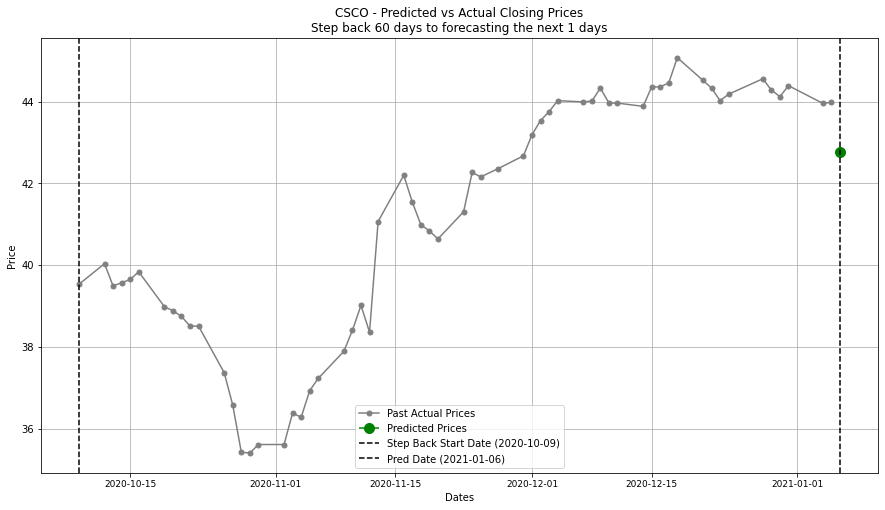

In [49]:
# Plotting predicted price
plt.figure(figsize=(15,8), facecolor='white')

plt.plot(actual, label="Past Actual Prices", color='grey', marker='o', markersize=5)
plt.plot(preds, label="Predicted Prices", color='g', ls='--', marker='o', markersize=10)

# plot the start and end of the step back periods
plt.axvline(x=actual.index[0], color='k', linestyle='--', label='Step Back Start Date ('+str(actual.index[0].date())+')')
plt.axvline(x=preds.index[0], color='k', linestyle='--', label='Pred Date ('+str(preds.index[0].date())+')')

plt.ylabel("Price")
plt.xlabel("Dates")
plt.xticks(fontsize=9)
plt.title(f'{test_comp} - Predicted vs Actual Closing Prices\nStep back {n_per_in} days to forecasting the next {n_per_out} days')
plt.legend()
plt.grid()
plt.savefig(IMAGE_DIR+test_comp+'pred_vs_actual_last_seq.png', facecolor='w', edgecolor='w',
            dpi=200, transparent=False, bbox_inches=None, pad_inches=0.1)
plt.show()

**Note:** Based on the past 60 periods data of all the features available, the model was able to predict 1 period future closing price (green dot)

In [50]:
# Creating a DF of the current real prices
real = one_comp_df[(one_comp_df['Date']>=lstm_data.index[-1]) & \
                   (one_comp_df['Date']<=preds.index[-1])][['Date', 'Close']].set_index('Date')
print(real.shape[0])
real

2


,Close
Date,
2021-01-05,43.980000
2021-01-06,44.400002


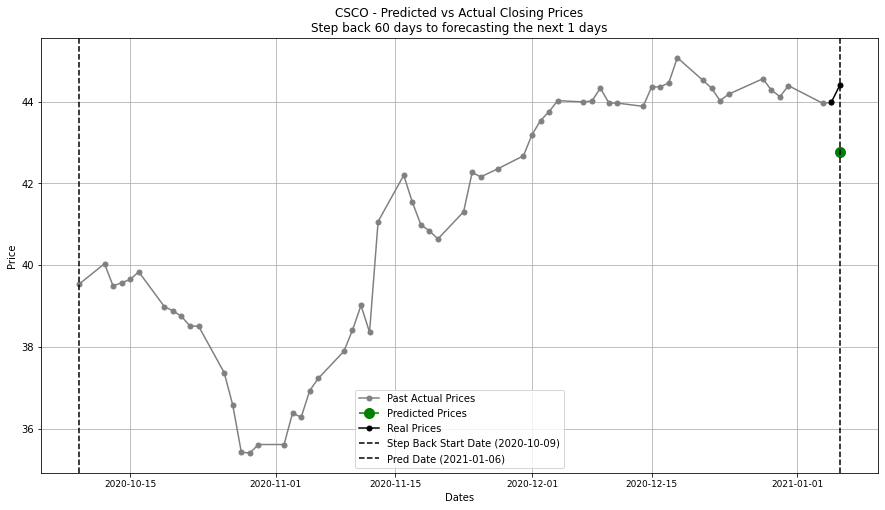

In [51]:
# Plotting predicted, actual price, current real price
plt.figure(figsize=(15,8), facecolor='white')
plt.plot(actual, label="Past Actual Prices", color='grey', marker='o', markersize=5)
plt.plot(preds, label="Predicted Prices", ls='--', color='g', marker='o', markersize=10)
plt.plot(real, label="Real Prices", color='k', marker='o', markersize=5)

# plot the start and end of the step back periods
plt.axvline(x=actual.index[0], color='k', linestyle='--', label='Step Back Start Date ('+str(actual.index[0].date())+')')
plt.axvline(x=preds.index[0], color='k', linestyle='--', label='Pred Date ('+str(preds.index[0].date())+')')

plt.ylabel("Price")
plt.xlabel("Dates")
plt.xticks(fontsize=9)
plt.title(f'{test_comp} - Predicted vs Actual Closing Prices\nStep back {n_per_in} days to forecasting the next {n_per_out} days')
plt.legend()
plt.grid()
plt.savefig(IMAGE_DIR+test_comp+'pred_vs_actual_vs_real_last_seq.png', facecolor='w', edgecolor='w',
            dpi=200, transparent=False, bbox_inches=None, pad_inches=0.1)
plt.show()

**Note:** For illustration purpose, we added the real closing price of the predicted date to the plot (black dot). In this CSCO example, we can see that the predicted closing price is neither close to the real closing price nor is it predicted to be in the same direction. Real closing price was an uptrend from last closing price but the predicted closing price is a downtrend. This shows that the model did not get the direction right for this future date.

## Visualize with Analyst's recommendations

Here we shall overlay the analyst's recommendation data to illustrate it effects on the prediction.

In [52]:
# read analyst recom data
analyst_recom_df

,date,recom_type,source,ticker,recom_type_ordinal
0,2015-10-23,Reiterated,Barclays,RCI,3
1,2015-12-04,Initiated,Goldman,RCI,2
2,2015-12-11,Upgrade,TD Securities,RCI,5
3,2015-12-17,Downgrade,Morgan Stanley,RCI,1
4,2016-04-19,Reiterated,RBC Capital Mkts,RCI,3
...,...,...,...,...,...
395,2021-01-14,Initiated,BMO Capital Markets,FBHS,2
396,2021-01-15,Initiated,Deutsche Bank,GSK,2
397,2021-01-20,Downgrade,Credit Suisse,GSK,1
398,2021-01-21,Upgrade,Credit Suisse,TRP,5


In [53]:
# sort and reset index
analyst_recom_df.sort_values(by='date', inplace=True)
analyst_recom_df.reset_index(drop=True, inplace=True)
analyst_recom_df

,date,recom_type,source,ticker,recom_type_ordinal
0,2015-10-23,Reiterated,Barclays,RCI,3
1,2015-12-04,Initiated,Goldman,RCI,2
2,2015-12-11,Upgrade,TD Securities,RCI,5
3,2015-12-17,Downgrade,Morgan Stanley,RCI,1
4,2016-04-19,Reiterated,RBC Capital Mkts,RCI,3
...,...,...,...,...,...
395,2021-01-14,Initiated,BMO Capital Markets,FBHS,2
396,2021-01-15,Initiated,Deutsche Bank,GSK,2
397,2021-01-20,Downgrade,Credit Suisse,GSK,1
398,2021-01-21,Upgrade,Credit Suisse,TRP,5


In [54]:
# filtering the dates of only the require company
analyst_tmp = analyst_recom_df[analyst_recom_df['ticker']==test_comp]
analyst_tmp_date_list = analyst_tmp['date'].tolist()
analyst_tmp_date_list

[Timestamp('2019-08-15 00:00:00'),
 Timestamp('2019-09-11 00:00:00'),
 Timestamp('2019-10-10 00:00:00'),
 Timestamp('2019-11-11 00:00:00'),
 Timestamp('2019-11-13 00:00:00'),
 Timestamp('2019-11-14 00:00:00'),
 Timestamp('2019-12-12 00:00:00'),
 Timestamp('2019-12-19 00:00:00'),
 Timestamp('2020-01-08 00:00:00'),
 Timestamp('2020-02-27 00:00:00'),
 Timestamp('2020-04-17 00:00:00'),
 Timestamp('2020-06-10 00:00:00'),
 Timestamp('2020-06-16 00:00:00'),
 Timestamp('2020-07-09 00:00:00'),
 Timestamp('2020-07-16 00:00:00'),
 Timestamp('2020-07-24 00:00:00'),
 Timestamp('2020-09-18 00:00:00'),
 Timestamp('2020-09-23 00:00:00'),
 Timestamp('2020-10-12 00:00:00'),
 Timestamp('2020-11-13 00:00:00')]

In [55]:
# filtering the date and close price matches
analyst_tmp_date_list_price = one_comp_df[one_comp_df['Date'].isin(analyst_tmp_date_list)][['Date', 'Close']]
analyst_tmp_date_list_price

,Date,Close
19761,2019-08-15,44.020245
19779,2019-09-11,47.618004
19800,2019-10-10,44.257759
19822,2019-11-11,46.127808
19824,2019-11-13,46.473042
19825,2019-11-14,43.068600
19844,2019-12-12,43.797436
19849,2019-12-19,45.916828
19861,2020-01-08,45.906601
19895,2020-02-27,38.680561


In [56]:
# merging the filtered list
analyst_tmp_merged = pd.merge(analyst_tmp, analyst_tmp_date_list_price, left_on='date', right_on='Date', indicator=True)

# filtering only analyst recom in the same date period 
analyst_tmp_merged = analyst_tmp_merged[(analyst_tmp_merged['date']>=actual.index.min()) & (analyst_tmp_merged['date']<=actual.index.max())]
analyst_tmp_merged

,date,recom_type,source,ticker,recom_type_ordinal,Date,Close,_merge
18,2020-10-12,Downgrade,Citigroup,CSCO,1,2020-10-12,40.035316,both
19,2020-11-13,Upgrade,New Street,CSCO,5,2020-11-13,41.066952,both


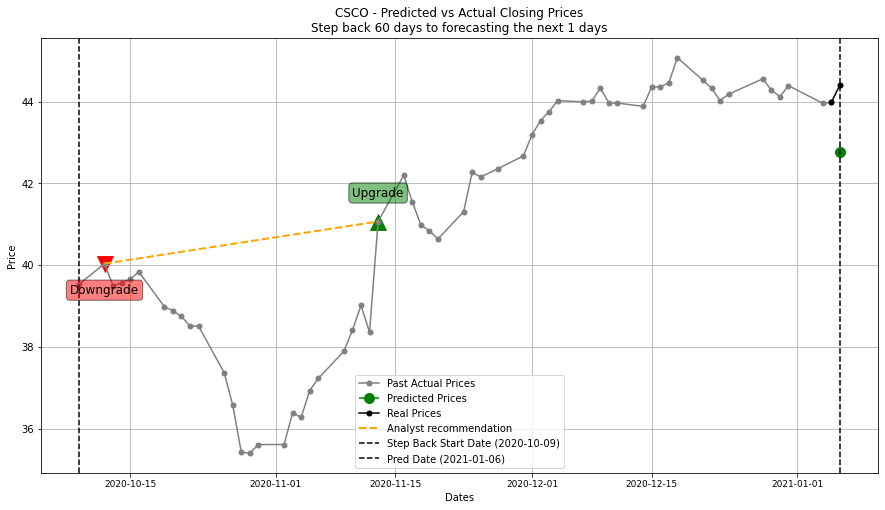

In [57]:
# plot that incorporate analyst action and price on the date of action
plt.figure(figsize=(15,8), facecolor='white')
plt.plot(actual, label='Past Actual Prices', color='grey', marker='o', markersize=5)
plt.plot(preds, label='Predicted Prices', ls='--', color='g', marker='o', markersize=10)
plt.plot(real, label='Real Prices', color='k', marker='o', markersize=5)

# analyst recom plot
analyst_tmp_x = analyst_tmp_merged.date.tolist()
analyst_tmp_y = analyst_tmp_merged.Close.tolist()
plt.plot(analyst_tmp_x, analyst_tmp_y, label='Analyst recommendation', color='orange', ls='--', lw=2)    

# analyst recom label
analyst_tmp_labels = analyst_tmp_merged.recom_type.tolist()
analyst_tmp_marker = ['^' if x in ['Upgrade', 'Resumed'] else 'v' if x in ['Downgrade', 'Reiterated'] \
                      else 'o' for x in analyst_tmp_merged['recom_type']]
label_offset = [25 if x in ['Upgrade', 'Resumed'] else -30 if x in ['Downgrade', 'Reiterated'] \
                      else 25 for x in analyst_tmp_merged['recom_type']]
for l,m,x,y,o in zip(analyst_tmp_labels, analyst_tmp_marker, analyst_tmp_x, analyst_tmp_y, label_offset):
    color = ''.join(['red' if m=='v' else 'green' if m=='^' else 'black'])
    plt.scatter(x,y, marker=m, c=color, s=250, zorder=1)
    plt.annotate(l, # this is the text
                 (x, y), # this is the point to label
                 textcoords='offset points', # how to position the text
                 xytext=(0,o), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center
                 bbox=dict(boxstyle="round", fc=color, alpha=0.5),
                 fontsize=12)
    
# plot the start and end of the step back periods
plt.axvline(x=actual.index[0], color='k', linestyle='--', label='Step Back Start Date ('+str(actual.index[0].date())+')')
plt.axvline(x=preds.index[0], color='k', linestyle='--', label='Pred Date ('+str(preds.index[0].date())+')')

plt.ylabel('Price')
plt.xlabel('Dates')
plt.xticks(fontsize=9)
plt.title(f'{test_comp} - Predicted vs Actual Closing Prices\nStep back {n_per_in} days to forecasting the next {n_per_out} days')
plt.legend()
plt.grid()
plt.savefig(IMAGE_DIR+test_comp+'pred_vs_actual_vs_real_last_seq_with_analyst.png', facecolor='w', edgecolor='w',
            dpi=200, transparent=False, bbox_inches=None, pad_inches=0.1)
plt.show()

**Note:** In this sequence of data for CSCO, there are only two analyst's recommendations with one being an upgrade while the other a downgrade. As it is not possible to open the hood to figure out how the neural network process every bit of data, we will try to make an educated inference from this plot.

From the downgrade recommendation, prices dropped from about 40 to 35 (range of 5) in about 10 periods of trading, so the model is likely to have learned that a downgrade has a bigger weight contribution to lower prices considering the amount dropped and the pace of drop, among other features data. On the other hand, from the upgrade recommendation, prices increased from about 41 to 45 (range of 4) but it took about 24 periods of trading to do so, so the model is likely to have learned that this upgrade call has a smaller contribution to higher prices given that it took longer to reach a similar range of change.

As mentioned there are other features data to consider as well but if we were to isolate only the analyst recommendations in this sequence plot. What we have describe is a very likely inference as to why the predicted future closing price is lower than real closing price.

## Visualize with News Sentiments

Here we shall overlay the news articles' sentimental analysis data to illustrate it effects on the prediction.

In [58]:
# read news sentiment data
senti_mean_df

,ticker,date,compound,Interpretation
0,ABBV,2020-11-24,0.180600,Positive
1,ABBV,2020-11-25,0.332600,Positive
2,ABBV,2020-11-27,0.127550,Positive
3,ABBV,2020-11-28,0.624900,Positive
4,ABBV,2020-11-29,0.000000,Neutral
...,...,...,...,...
1083,SAP,2021-01-15,0.236533,Positive
1084,SAP,2021-01-19,0.159100,Positive
1085,SAP,2021-01-20,0.000000,Neutral
1086,SAP,2021-01-21,0.273200,Positive


In [59]:
# filtering for only the required company
senti_mean_tmp = senti_mean_df[senti_mean_df['ticker']==test_comp]
print(senti_mean_tmp.shape)
senti_mean_tmp

(37, 4)


,ticker,date,compound,Interpretation
94,CSCO,2020-12-07,0.000000,Neutral
95,CSCO,2020-12-08,0.089700,Positive
96,CSCO,2020-12-09,0.000000,Neutral
97,CSCO,2020-12-12,0.000000,Neutral
98,CSCO,2020-12-13,0.636900,Positive
99,CSCO,2020-12-15,0.096900,Positive
100,CSCO,2020-12-17,0.197850,Positive
101,CSCO,2020-12-18,0.090925,Positive
102,CSCO,2020-12-19,0.624900,Positive
103,CSCO,2020-12-20,0.440400,Positive


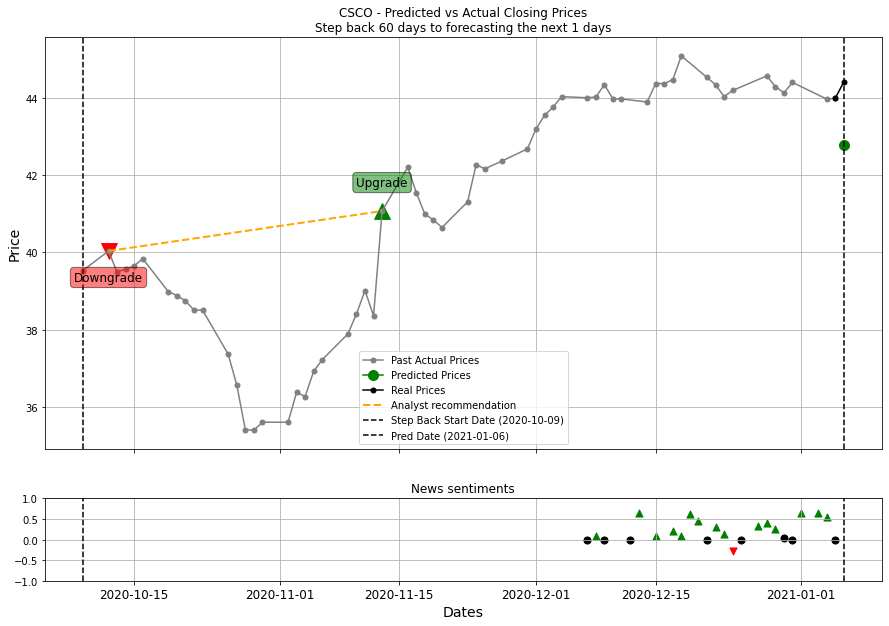

In [60]:
# plot that incorporate news sentiments
fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw={'height_ratios': [5, 1]},
                               figsize=(15,10), facecolor='white', sharex=True)

# plots on ax1
ax1.plot(actual, label='Past Actual Prices', color='grey', marker='o', markersize=5)
ax1.plot(preds, label='Predicted Prices', ls='-', color='g', marker='o', markersize=10)
ax1.plot(real, label='Real Prices', color='k', marker='o', markersize=5)

# analyst recom plot
analyst_tmp_x = analyst_tmp_merged.date.tolist()
analyst_tmp_y = analyst_tmp_merged.Close.tolist()
ax1.plot(analyst_tmp_x, analyst_tmp_y, label='Analyst recommendation', color='orange', ls='--', lw=2)    

# analyst recom label
analyst_tmp_labels = analyst_tmp_merged.recom_type.tolist()
analyst_tmp_marker = ['^' if x in ['Upgrade', 'Resumed'] else 'v' if x in ['Downgrade', 'Reiterated'] \
                      else 'o' for x in analyst_tmp_merged['recom_type']]
label_offset = [25 if x in ['Upgrade', 'Resumed'] else -30 if x in ['Downgrade', 'Reiterated'] \
                      else 25 for x in analyst_tmp_merged['recom_type']]
for l,m,x,y,o in zip(analyst_tmp_labels, analyst_tmp_marker, analyst_tmp_x, analyst_tmp_y, label_offset):
    color = ''.join(['red' if m=='v' else 'green' if m=='^' else 'black'])
    ax1.scatter(x,y, marker=m, c=color, s=250, zorder=1)
    ax1.annotate(l, # this is the text
                 (x, y), # this is the point to label
                 textcoords='offset points', # how to position the text
                 xytext=(0,o), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center
                 bbox=dict(boxstyle="round", fc=color, alpha=0.5),
                 fontsize=12)
    
# plot the start and end of the step back periods
ax1.axvline(x=actual.index[0], color='k', linestyle='--', label='Step Back Start Date ('+str(actual.index[0].date())+')')
ax1.axvline(x=preds.index[0], color='k', linestyle='--', label='Pred Date ('+str(preds.index[0].date())+')')

ax1.set_title(f'{test_comp} - Predicted vs Actual Closing Prices\nStep back {n_per_in} days to forecasting the next {n_per_out} days')
ax1.set_ylabel('Price', fontsize=14)
ax1.legend()
ax1.grid()

# plots on ax2
# news sentiment plots
senti_mean_tmp_labels = ['^' if x=='Positive' else 'v' if x=='Negative' else 'o' \
                         for x in senti_mean_tmp['Interpretation']]

senti_mean_tmp_x = senti_mean_tmp[(senti_mean_tmp['date']>=actual.index.min()) & \
                                  (senti_mean_tmp['date']<=actual.index.max())]['date'].tolist()

senti_mean_tmp_y = senti_mean_tmp['compound']

for l,x,y in zip(senti_mean_tmp_labels, senti_mean_tmp_x, senti_mean_tmp_y):
    color = ''.join(['red' if l=='v' else 'green' if l=='^' else 'black'])
    ax2.scatter(x,y, marker=l, c=color, s=50)

# plot the start and end of the step back periods
ax2.axvline(x=actual.index[0], color='k', linestyle='--', label='Step Back Start Date ('+str(actual.index[0].date())+')')
ax2.axvline(x=preds.index[0], color='k', linestyle='--', label='Pred Date ('+str(preds.index[0].date())+')')

ax2.set_title('News sentiments')
ax2.set_xlabel('Dates', fontsize=14)
plt.xticks(fontsize=12)
ax2.grid()
ax2.set_ylim(-1,1)

plt.savefig(IMAGE_DIR+test_comp+'pred_vs_actual_vs_real_last_seq_with_analyst_and_news.png', facecolor='w', edgecolor='w',
            dpi=200, transparent=False, bbox_inches=None, pad_inches=0.1)
plt.show()

**Note:** In this sequence of 60 periods, we observed that there are no news articles in the earlier 2/3 of the sequence and there are much more positive (green) and neutral (black) news than negative (red) news. Intuitively, one would infer that with majority positive news, the prediction should be going on an uptrend. However, the model predicted to be a downtrend instead. This could be due to other features data coming into play as well that resulted in a downtrend prediction.

This again illustrates that with neural network inner workings, it is not always possible to decipher why a certain result occurs. Much more so when we are modeling stock prices among many other features data. However, we have to also remember and appreciate that interpreting and processing these large amount of data manually is impossible without the help of machine learning.

This in fact is a good point to pause the illustration because it is a clear evident that we cannot rely on interpreting just one sequence result to determine the effectiveness of the model. A total and collective evaluation of how the model perform for each company and also for the collection of companies in the portfolio should be the ultimate evaluation metric in our project context. In the real investment world, the success of an investor is also not measure based on one company he/she invested in but rather his entire portfolio performance over time.

# Create a Trading Account Class

We will need to create a new Trading Account Class object to store and perform trading actions arising from our trading strategy in subsequent stage. This class takes care of the initialization of account, deposit, withdraw, balances, freezing/unfreezing whenever call for while executing the trading strategy.

In [23]:
# create a trading account class object
class ticker_account:   
    def __init__(self, ticker, acct_start_bal):
        self.ticker = ticker
        self.share_balance = 0
        self.value_balance = acct_start_bal
        self.pos_hold_value = 0
        self.frozen = False
    
    # buying shares
    def deposit(self, date, trans_price, trade_size):
        result = []
        if not self.frozen:
            # calculate require amount
            trans_amount = trade_size*trans_price
            comm_fees = trans_amount*comm_rate  # commission and fees percentage
            # checking and imposing min fee of 25
            if comm_fees < min_fees:
                comm_fees = min_fees
            else:
                pass
            total_amt = -(trans_amount+comm_fees) # trans+amount PLUS commission and fees
            
            # check if enough money to buy
            if self.value_balance + total_amt < 0:
                print(date, 'ERROR! Insufficient money to buy shares.')
                print(f'{self.ticker} account has {round(self.value_balance,2)} remaining.', '\n')
                print('------------------------------\n')
                result = 'fail'
                return result
            
            elif self.value_balance + total_amt >= 0:                
                self.share_balance += trade_size
                self.value_balance += total_amt
                self.pos_hold_value += abs(total_amt)
                print(f'{date} Bought {trade_size} of {self.ticker} at OPEN {round(trans_price,2)} = $ {round(trans_amount,2)}.')
                print(f'- Commission and fees     = $ {round(comm_fees,2)}')
                print(f'- Total amount            = $ {round(total_amt,2)}')
                print(f'- Remaining qty           = {self.share_balance}')
                print(f'- Ramaining valued at     = $ {round(self.pos_hold_value,2)}')
                print(f'- Account current balance = $ {round(self.value_balance,2)}','\n')
                result = 'pass'
        else:
            print('Cannot buy - account is frozen!')
        return result
                      
    # selling shares
    def withdraw(self, date, trans_price, trade_size):
        result = []
        if not self.frozen:
            # check if account have zero share or try to short sell = not allow
            if self.share_balance==0:
                print(date, 'ERROR! Short selling not allow.')
                print(f'{self.ticker} account only has {round(self.share_balance,2)} remaining.', '\n')
                result = 'fail'
                return result
            
            elif self.share_balance - trade_size >= 0:
                # calculate require amount
                trans_amount = trade_size*trans_price
                comm_fees = trans_amount*comm_rate  # commission and fees percentage
                # checking and imposing min fee of 25
                if comm_fees < min_fees:
                    comm_fees = min_fees
                else:
                    pass
                total_amt = trans_amount-comm_fees # trans_amount MINUS commission and fees
                
                # check if trans_profit can cover comm
                if total_amt - self.pos_hold_value <= comm_fees:
                    print(f'Transaction value (incl. comm & fees) = $ {round(total_amt,2)}')
                    print('Transaction profit cannot cover commission so HOLD')
                    print('------------------------------\n')
                    result = 'fail'
                    return result
                else:
                    self.share_balance -= trade_size
                    self.value_balance += total_amt
                    self.pos_hold_value = 0
                    print(f'{date} Sold {trade_size} of {self.ticker} at OPEN {round(trans_price,2)} = $ {round(trans_amount,2)}.')
                    print(f'- Commission and fees  = $ {round(comm_fees,2)}')
                    print(f'- Total amount         = {round(total_amt,2)}')
                    print(f'- Remaining qty        = {self.share_balance}')
                    print(f'- Remaining valued at  = $ {round(self.pos_hold_value,2)}')
                    print(f'- Account balance      = $ {round(self.value_balance,2)}','\n')
                    result = 'pass'
            else:
                print('ERROR CHECK WITHDRAW FUNCTION!!\n')
        else:
            print('CANNOT SELL - ACCOUNT IS FROZEN!!\n')
        return result

    # check balances
    def view_balance(self):
        print(f'{self.ticker} account has {self.share_balance} shares remaining.')
        print(f'{self.ticker} account has $ {round(self.pos_hold_value,2)} shares on hand value.')
        print(f'{self.ticker} account has $ {round(self.value_balance,2)} remaining.')
        print('------------------------------\n')
        return self.value_balance

    # account freeze
    def _freeze(self):
        self.frozen = True
    
    # account unfreeze
    def _unfreeze(self):
        self.frozen = False
                

# Create a Trading Robot

A trading robot functions are created to handle the records keeping task of our trading actions. This will allow us to review and audit the trade actions to ensure it was done correctly as planned and it can also help us to fine-tune the trading strategy.

In [24]:
# helper function for buy action
def buy_record(test_comp, comp_account, date, trans_price, trade_size, pred_trend):
    trans_record = []
    trans_amount = trade_size*trans_price
    comm_fees = trans_amount*comm_rate  # commission and fees percentage
    
    # checking and imposing min fee of 25
    if comm_fees < min_fees:
        comm_fees = min_fees
    else:
        pass
    
    total_amt = -(trans_amount+comm_fees) # add commission and fees
    
    trans_record.append({'trans_date': date, 'ticker' : test_comp, 'qty' : trade_size,
                         'price' : trans_price, 'action' : 'buy', 'comm_fees' : comm_fees,
                         'trans_amount' : trans_amount, 'total_plus_comm_fees' : total_amt,
                         'acct_bal' : comp_account.view_balance(), 'pred_trend' : pred_trend})
    return trans_record

In [25]:
# helper function for sell action
def sell_record(test_comp, comp_account, date, trans_price, trade_size, pred_trend):
    trans_record = []
    trans_amount = trade_size*trans_price
    comm_fees = trans_amount*comm_rate  # commission and fees percentage
    
    # checking and imposing min fee of 25
    if comm_fees < min_fees:
        comm_fees = min_fees
    else:
        pass
    
    total_amt = trans_amount-comm_fees # minus commission and fees
    
    trans_record.append({'trans_date': date, 'ticker' : test_comp, 'qty' : trade_size,
                         'price' : trans_price, 'action' : 'sell', 'comm_fees' : comm_fees,
                         'trans_amount' : trans_amount, 'total_plus_comm_fees' : total_amt,
                         'acct_bal' : comp_account.view_balance(), 'pred_trend' : pred_trend})
    return trans_record

In [26]:
# helper function for hold action
def hold_record(test_comp, comp_account, date, trans_price, trade_size, pred_trend):
    trans_record = []
    trans_amount = 0
    comm_fees = 0  # commission and fees percentage 0.2% per trade
    total_amt = trans_amount+comm_fees # minus commission and fees

    trans_record.append({'trans_date': date, 'ticker' : test_comp, 'qty' : trade_size,
                         'price' : trans_price, 'action' : 'hold', 'comm_fees' : comm_fees,
                         'trans_amount' : trans_amount, 'total_plus_comm_fees' : total_amt,
                         'acct_bal' : comp_account.view_balance(), 'pred_trend' : pred_trend})
    return trans_record

In [27]:
# helper function for non-trading day
def non_trade_record(test_comp, date):
    trans_record = []
    trans_record.append({'trans_date': date, 'ticker' : test_comp, 'qty' : '-',
                         'price' : '-', 'action' : '-', 'comm_fees' : '-',
                         'trans_amount' : '-', 'total_plus_comm_fees' : '-',
                         'acct_bal' : '-', 'pred_trend' : '-'})
    return trans_record

# Backtesting long term simple strategy

**Buy low, Sell high, No short, No min commission/fees**

In order to make a complete and meaning assessment of the ML model, the best way is to apply the predictions and backtest them over a period to simulate a real investment. There are ready made backtesting libraries out there but we decided to build our own from scratch because only in this way can we look under the hood to evaluate and audit if our model and trading strategy actually work as intended.

We shall design a simple strategy that gives absolute trust to the model's predictions and taking no risk at all based on the following rules.

1. Whenever tomorrow close price is predicted to be higher than today close price by a predicted percentage gain. We shall buy at tomorrow open price.

2. Whenever tomorrow close price is predicted to be lower than today close price. We shall sell everything on hand at tomorrow open price.

3. At all time, there will be no short selling transaction.

4. In all buy trades, we will adjust the trade size such that the commission/fees is not lower than the min fees.

5. In all sell trades, we will not enter a sell trade if the resulting predicted gain is lower than the min fees.

Recall that we made these variables declaration in the "IMPORTANT VARIABLES SETTINGS" section.
```
# setting account starting balance and pred_pct_gain in daily prices before making a trade
acct_start_bal = 50000
pred_pct_gain = 1.05

# setting commission and fees (based on DBS OET US market fees)
comm_rate = 0.0015 # 0.15% on trans_amount each time but a min. of $18 will be imposed in the buy/sell functions
min_fees = 18
```

We shall test the <font color=green>"tuned" model</font> and our simple strategy over a long term investment horizon of 20 yrs as well as a shorter 1 yr horizon. This will truly be a complete evaluation of our "un-tune" vs "tuned" models over different investment horizon and compare between a domain knowledge portfolio vs a unsupervised learning Kmeans portfolio.

## Settings

In [61]:
# set and check boundaries
backtest_start = predictions.index.min()

# leaving out the date ranges where we did not make any predictions
backtest_end = predictions.tail(n_per_in).index.min() - datetime.timedelta(days=n_per_out)
print(backtest_start)
print(backtest_end)

2000-01-03 00:00:00
2020-10-08 00:00:00


In [62]:
# combining predictions with actuals
backtest_data = pd.merge(lstm_data, predictions, left_on=lstm_data.index, right_on=predictions.index)
backtest_data.rename(columns={'key_0': 'date', 'Close_x': 'Close', 'Close_y': 'pred_close'}, inplace=True)

# filtering backtest_data to date ranges where we have made a prediction
backtest_data = backtest_data[(backtest_data.date>=backtest_start) & (backtest_data.date<=backtest_end)]
print(backtest_data.shape)
backtest_data.head()

(5226, 14)


,date,Open,High,Low,Volume,Close,SMA20,RSI14,MOM5,OBV,ATR14,recom_type_ordinal,compound,pred_close
0,2000-01-03,41.107361,41.224210,38.723648,53076000.0,40.406269,38.190832,73.983820,1.074997,1.792563e+10,1.256790,0.0,0.0,NaN
1,2000-01-04,39.448125,40.008999,38.045941,50805600.0,38.139420,38.260941,55.907587,-1.191853,1.787482e+10,1.335614,0.0,0.0,NaN
2,2000-01-05,37.414962,39.074214,36.363323,68524000.0,38.022575,38.264447,55.159485,-1.659248,1.780630e+10,1.433848,0.0,0.0,NaN
3,2000-01-06,37.695389,38.092675,36.877448,48242600.0,37.391582,38.265615,51.176894,-2.313610,1.775806e+10,1.418233,0.0,0.0,NaN
4,2000-01-07,37.157902,39.635096,37.157902,62260600.0,39.588356,38.401160,61.577839,-0.467384,1.782032e+10,1.493873,0.0,0.0,NaN


In [63]:
# fill nan with 0 for record rows without prediction values
backtest_data['pred_close'].fillna(0, inplace=True)
backtest_data.tail()

,date,Open,High,Low,Volume,Close,SMA20,RSI14,MOM5,OBV,ATR14,recom_type_ordinal,compound,pred_close
5221,2020-10-02,37.743896,38.239874,37.664542,24493000.0,37.962128,38.837444,35.906999,0.170029,2.132684e+10,0.807506,0.0,0.0,37.749210
5222,2020-10-05,38.170440,38.477947,37.972048,26929100.0,38.259716,38.744353,39.097353,-0.200748,2.135377e+10,0.786671,0.0,0.0,37.810986
5223,2020-10-06,38.190279,39.033440,38.091085,28430800.0,38.259716,38.691560,39.097353,-0.131947,2.135377e+10,0.797791,0.0,0.0,38.008751
5224,2020-10-07,38.666415,39.261591,38.468023,20593700.0,39.083038,38.673544,47.484914,0.367023,2.137436e+10,0.812369,0.0,0.0,38.685303
5225,2020-10-08,39.479820,39.856764,39.340947,19031300.0,39.469902,38.702392,50.906270,0.982037,2.139339e+10,0.809608,0.0,0.0,39.207836


In [64]:
# drop duplicated rows
print(backtest_data.duplicated().sum())
backtest_data.drop_duplicates(inplace=True)
backtest_data.reset_index(drop=True, inplace=True)
backtest_data.shape

0


(5226, 14)

In [65]:
# initialize account class
comp_account = ticker_account(test_comp, acct_start_bal)
print(f'Account starting balance $ {comp_account.value_balance}')

Account starting balance $ 50000


In [66]:
# executing the strategy
all_trans_record = []

for i in range(1, backtest_data.shape[0]):
    trans_record = []
    trade_size = 10

    if backtest_data['pred_close'][i] <= 0:
        #print(i, 'Error!! Null or negative prediction')
        #trans_record = non_trade_record(test_comp, backtest_data['date'][i])
        # function is defined but not triggering to reduce clutter as the first 60 periods have
        # no prediction values (which is correct)
        pass
    
    # tmr pred close same as tdy close price, HOLD
    elif backtest_data['pred_close'][i] == backtest_data['Close'][i-1]:
        print(i, 'tmr close = tdy close so HOLD')
        pred_trend = 'no change'
        trans_price = 0
        trade_size = 0
        trans_record = hold_record(test_comp, comp_account, backtest_data['date'][i], trans_price, trade_size, pred_trend)
        
    # tmr pred close higher than tdy close by a certain %, BUY
    elif (backtest_data['pred_close'][i] > backtest_data['Close'][i-1]) and\
         (backtest_data['pred_close'][i] / backtest_data['Close'][i-1]) >= pred_pct_gain:
        
        print(f'{i}, Tmr pred close {round(backtest_data.pred_close[i],2)} >({pred_pct_gain}%) Tdy close {round(backtest_data.Close[i-1],2)} so BUY')
        pred_trend = 'up'
        trans_price = backtest_data['Open'][i]
        
        # checking and adjusting trade_size to make paying min_fees worth it
        while (trade_size*trans_price*comm_rate) < min_fees:
            trade_size += 10
       
        if comp_account.deposit(backtest_data['date'][i], trans_price, trade_size)=='pass': # able to buy
            trans_record = buy_record(test_comp, comp_account, backtest_data['date'][i], trans_price, trade_size, pred_trend)
        else:
            print(f'{i}, {backtest_data.date[i]} Insufficient money to buy shares.')
            print('------------------------------\n')
            trade_size = 0
            trans_record = hold_record(test_comp, comp_account, backtest_data['date'][i], trans_price, trade_size, pred_trend)
            
    # tmr pred close lower than tdy close, SELL
    elif backtest_data['pred_close'][i] < backtest_data['Close'][i-1]:
        print(f'{i}, Tmr pred close {round(backtest_data.pred_close[i],2)} < Tdy close {round(backtest_data.Close[i-1],2)} so SELL')
        pred_trend = 'down'
        trans_price = backtest_data['Open'][i]
        trade_size = comp_account.share_balance
        if comp_account.withdraw(backtest_data['date'][i], trans_price, trade_size)=='pass': # able to sell
            trans_record = sell_record(test_comp, comp_account, backtest_data['date'][i], trans_price, trade_size, pred_trend)
        else:
            print(f'{i}, {backtest_data.date[i]} Short selling not allow.')
            print('------------------------------\n')
            trade_size = 0
            trans_record = hold_record(test_comp, comp_account, backtest_data['date'][i], trans_price, trade_size, pred_trend)
    else:
        print(f'{i}, {backtest_data.date[i]} NO TRADING RECOMMENDATION TODAY')
        print('------------------------------\n')
        # recording price_trend only
        if (backtest_data['pred_close'][i] > backtest_data['Close'][i-1]):
            pred_trend = 'up'
            trans_price = 0
            trade_size = 0
            trans_record = hold_record(test_comp, comp_account, backtest_data['date'][i], trans_price, trade_size, pred_trend)
        elif backtest_data['pred_close'][i] < backtest_data['Close'][i-1]:
            pred_trend = 'down'
            trans_price = 0
            trade_size = 0
            trans_record = hold_record(test_comp, comp_account, backtest_data['date'][i], trans_price, trade_size, pred_trend)       
            
    all_trans_record.append(trans_record)

60, Tmr pred close 51.01 < Tdy close 58.24 so SELL
2000-03-29 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remaining. 

60, 2000-03-29 00:00:00 Short selling not allow.
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 50000 remaining.
------------------------------

61, Tmr pred close 50.56 < Tdy close 56.88 so SELL
2000-03-30 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remaining. 

61, 2000-03-30 00:00:00 Short selling not allow.
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 50000 remaining.
------------------------------

62, Tmr pred close 50.19 < Tdy close 55.06 so SELL
2000-03-31 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remaining. 

62, 2000-03-31 00:00:00 Short selling not allow.
------------------------------

CSCO account has 0 shares remaining.
CSCO

CSCO account has $ 51292.89 remaining.
------------------------------

150, Tmr pred close 45.92 < Tdy close 49.03 so SELL
2000-08-07 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remaining. 

150, 2000-08-07 00:00:00 Short selling not allow.
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 51292.89 remaining.
------------------------------

151, Tmr pred close 46.07 < Tdy close 49.54 so SELL
2000-08-08 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remaining. 

151, 2000-08-08 00:00:00 Short selling not allow.
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 51292.89 remaining.
------------------------------

152, Tmr pred close 46.47 < Tdy close 48.98 so SELL
2000-08-09 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remaining. 

152, 2000-08-09 00:00:00 Short selling n

197, Tmr pred close 37.4 < Tdy close 38.28 so SELL
2000-10-12 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remaining. 

197, 2000-10-12 00:00:00 Short selling not allow.
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 51292.89 remaining.
------------------------------

198, Tmr pred close 39.27 >(1.05%) Tdy close 37.25 so BUY
2000-10-13 00:00:00 Bought 330 of CSCO at OPEN 36.69 = $ 12107.87.
- Commission and fees     = $ 18.16
- Total amount            = $ -12126.03
- Remaining qty           = 330
- Ramaining valued at     = $ 12126.03
- Account current balance = $ 39166.86 

CSCO account has 330 shares remaining.
CSCO account has $ 12126.03 shares on hand value.
CSCO account has $ 39166.86 remaining.
------------------------------

199, Tmr pred close 40.3 < Tdy close 41.93 so SELL
2000-10-16 00:00:00 Sold 330 of CSCO at OPEN 41.27 = $ 13619.42.
- Commission and fees  = $ 20.43
- Tot

2001-03-08 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remaining. 

297, 2001-03-08 00:00:00 Short selling not allow.
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 60653.97 remaining.
------------------------------

298, Tmr pred close 16.63 < Tdy close 17.06 so SELL
2001-03-09 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remaining. 

298, 2001-03-09 00:00:00 Short selling not allow.
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 60653.97 remaining.
------------------------------

299, 2001-03-12 00:00:00 NO TRADING RECOMMENDATION TODAY
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 60653.97 remaining.
------------------------------

300, Tmr pred close 15.71 >(1.05%) Tdy close 14.07 so BUY
2001-0

2001-04-11 00:00:00 ERROR! Insufficient money to buy shares.
CSCO account has 909.93 remaining. 

------------------------------

321, 2001-04-11 00:00:00 Insufficient money to buy shares.
------------------------------

CSCO account has 5380 shares remaining.
CSCO account has $ 60356.76 shares on hand value.
CSCO account has $ 909.93 remaining.
------------------------------

322, 2001-04-12 00:00:00 NO TRADING RECOMMENDATION TODAY
------------------------------

CSCO account has 5380 shares remaining.
CSCO account has $ 60356.76 shares on hand value.
CSCO account has $ 909.93 remaining.
------------------------------

323, Tmr pred close 13.22 < Tdy close 13.45 so SELL
2001-04-16 00:00:00 Sold 5380 of CSCO at OPEN 13.2 = $ 71011.89.
- Commission and fees  = $ 106.52
- Total amount         = 70905.37
- Remaining qty        = 0
- Remaining valued at  = $ 0
- Account balance      = $ 71815.3 

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account h

CSCO account has $ 81748.71 remaining.
------------------------------

364, Tmr pred close 14.95 < Tdy close 15.23 so SELL
2001-06-13 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remaining. 

364, 2001-06-13 00:00:00 Short selling not allow.
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 81748.71 remaining.
------------------------------

365, 2001-06-14 00:00:00 NO TRADING RECOMMENDATION TODAY
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 81748.71 remaining.
------------------------------

366, Tmr pred close 14.03 >(1.05%) Tdy close 13.27 so BUY
2001-06-15 00:00:00 Bought 940 of CSCO at OPEN 12.9 = $ 12126.09.
- Commission and fees     = $ 18.19
- Total amount            = $ -12144.28
- Remaining qty           = 940
- Ramaining valued at     = $ 12144.28
- Account current balance = $ 69604.42 

CSC


CSCO account has 1020 shares remaining.
CSCO account has $ 12031.94 shares on hand value.
CSCO account has $ 85022.03 remaining.
------------------------------

455, Tmr pred close 13.03 < Tdy close 13.27 so SELL
2001-10-26 00:00:00 Sold 1020 of CSCO at OPEN 13.0 = $ 13257.26.
- Commission and fees  = $ 19.89
- Total amount         = 13237.37
- Remaining qty        = 0
- Remaining valued at  = $ 0
- Account balance      = $ 98259.4 

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 98259.4 remaining.
------------------------------

456, Tmr pred close 12.92 < Tdy close 12.93 so SELL
2001-10-29 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remaining. 

456, 2001-10-29 00:00:00 Short selling not allow.
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 98259.4 remaining.
------------------------------

457, 2001-10-30 00:00:00 NO TRADING RE

------------------------------

508, Tmr pred close 14.93 < Tdy close 15.11 so SELL
2002-01-14 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remaining. 

508, 2002-01-14 00:00:00 Short selling not allow.
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 100030.04 remaining.
------------------------------

509, 2002-01-15 00:00:00 NO TRADING RECOMMENDATION TODAY
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 100030.04 remaining.
------------------------------

510, Tmr pred close 14.67 < Tdy close 14.72 so SELL
2002-01-16 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remaining. 

510, 2002-01-16 00:00:00 Short selling not allow.
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 100030.04 remaining.
---------

CSCO account has 4799.65 remaining. 

------------------------------

614, 2002-06-17 00:00:00 Insufficient money to buy shares.
------------------------------

CSCO account has 9410 shares remaining.
CSCO account has $ 108609.8 shares on hand value.
CSCO account has $ 4799.65 remaining.
------------------------------

615, Tmr pred close 12.05 >(1.05%) Tdy close 11.27 so BUY
2002-06-18 00:00:00 ERROR! Insufficient money to buy shares.
CSCO account has 4799.65 remaining. 

------------------------------

615, 2002-06-18 00:00:00 Insufficient money to buy shares.
------------------------------

CSCO account has 9410 shares remaining.
CSCO account has $ 108609.8 shares on hand value.
CSCO account has $ 4799.65 remaining.
------------------------------

616, Tmr pred close 12.0 >(1.05%) Tdy close 11.0 so BUY
2002-06-19 00:00:00 ERROR! Insufficient money to buy shares.
CSCO account has 4799.65 remaining. 

------------------------------

616, 2002-06-19 00:00:00 Insufficient money to buy s

652, Tmr pred close 10.94 >(1.05%) Tdy close 9.87 so BUY
2002-08-09 00:00:00 ERROR! Insufficient money to buy shares.
CSCO account has 4799.65 remaining. 

------------------------------

652, 2002-08-09 00:00:00 Insufficient money to buy shares.
------------------------------

CSCO account has 9410 shares remaining.
CSCO account has $ 108609.8 shares on hand value.
CSCO account has $ 4799.65 remaining.
------------------------------

653, Tmr pred close 11.08 >(1.05%) Tdy close 9.81 so BUY
2002-08-12 00:00:00 ERROR! Insufficient money to buy shares.
CSCO account has 4799.65 remaining. 

------------------------------

653, 2002-08-12 00:00:00 Insufficient money to buy shares.
------------------------------

CSCO account has 9410 shares remaining.
CSCO account has $ 108609.8 shares on hand value.
CSCO account has $ 4799.65 remaining.
------------------------------

654, Tmr pred close 11.13 >(1.05%) Tdy close 10.03 so BUY
2002-08-13 00:00:00 ERROR! Insufficient money to buy shares.
CSC

2002-12-17 00:00:00 ERROR! Insufficient money to buy shares.
CSCO account has 4799.65 remaining. 

------------------------------

742, 2002-12-17 00:00:00 Insufficient money to buy shares.
------------------------------

CSCO account has 9410 shares remaining.
CSCO account has $ 108609.8 shares on hand value.
CSCO account has $ 4799.65 remaining.
------------------------------

743, Tmr pred close 11.19 >(1.05%) Tdy close 10.22 so BUY
2002-12-18 00:00:00 ERROR! Insufficient money to buy shares.
CSCO account has 4799.65 remaining. 

------------------------------

743, 2002-12-18 00:00:00 Insufficient money to buy shares.
------------------------------

CSCO account has 9410 shares remaining.
CSCO account has $ 108609.8 shares on hand value.
CSCO account has $ 4799.65 remaining.
------------------------------

744, Tmr pred close 11.03 >(1.05%) Tdy close 9.89 so BUY
2002-12-19 00:00:00 ERROR! Insufficient money to buy shares.
CSCO account has 4799.65 remaining. 

----------------------

------------------------------

782, Tmr pred close 11.26 >(1.05%) Tdy close 9.95 so BUY
2003-02-14 00:00:00 ERROR! Insufficient money to buy shares.
CSCO account has 4799.65 remaining. 

------------------------------

782, 2003-02-14 00:00:00 Insufficient money to buy shares.
------------------------------

CSCO account has 9410 shares remaining.
CSCO account has $ 108609.8 shares on hand value.
CSCO account has $ 4799.65 remaining.
------------------------------

783, Tmr pred close 11.47 >(1.05%) Tdy close 10.23 so BUY
2003-02-18 00:00:00 ERROR! Insufficient money to buy shares.
CSCO account has 4799.65 remaining. 

------------------------------

783, 2003-02-18 00:00:00 Insufficient money to buy shares.
------------------------------

CSCO account has 9410 shares remaining.
CSCO account has $ 108609.8 shares on hand value.
CSCO account has $ 4799.65 remaining.
------------------------------

784, Tmr pred close 11.65 >(1.05%) Tdy close 10.7 so BUY
2003-02-19 00:00:00 ERROR! Insuf

------------------------------

CSCO account has 9410 shares remaining.
CSCO account has $ 108609.8 shares on hand value.
CSCO account has $ 4799.65 remaining.
------------------------------

862, Tmr pred close 13.68 >(1.05%) Tdy close 13.01 so BUY
2003-06-11 00:00:00 ERROR! Insufficient money to buy shares.
CSCO account has 4799.65 remaining. 

------------------------------

862, 2003-06-11 00:00:00 Insufficient money to buy shares.
------------------------------

CSCO account has 9410 shares remaining.
CSCO account has $ 108609.8 shares on hand value.
CSCO account has $ 4799.65 remaining.
------------------------------

863, 2003-06-12 00:00:00 NO TRADING RECOMMENDATION TODAY
------------------------------

CSCO account has 9410 shares remaining.
CSCO account has $ 108609.8 shares on hand value.
CSCO account has $ 4799.65 remaining.
------------------------------

864, 2003-06-13 00:00:00 NO TRADING RECOMMENDATION TODAY
------------------------------

CSCO account has 9410 shares r

------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 134931.22 remaining.
------------------------------

918, 2003-08-29 00:00:00 NO TRADING RECOMMENDATION TODAY
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 134931.22 remaining.
------------------------------

919, 2003-09-02 00:00:00 NO TRADING RECOMMENDATION TODAY
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 134931.22 remaining.
------------------------------

920, 2003-09-03 00:00:00 NO TRADING RECOMMENDATION TODAY
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 134931.22 remaining.
------------------------------

921, 2003-09-04 00:00:00 NO TRADING RECOMMENDATION TODAY
------------------------------

CSCO

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 134931.22 remaining.
------------------------------

1077, 2004-04-19 00:00:00 NO TRADING RECOMMENDATION TODAY
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 134931.22 remaining.
------------------------------

1078, Tmr pred close 17.01 < Tdy close 17.1 so SELL
2004-04-20 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remaining. 

1078, 2004-04-20 00:00:00 Short selling not allow.
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 134931.22 remaining.
------------------------------

1079, 2004-04-21 00:00:00 NO TRADING RECOMMENDATION TODAY
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 134931.22 remaining.
--------------------

2004-06-03 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remaining. 

1109, 2004-06-03 00:00:00 Short selling not allow.
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 134931.22 remaining.
------------------------------

1110, 2004-06-04 00:00:00 NO TRADING RECOMMENDATION TODAY
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 134931.22 remaining.
------------------------------

1111, 2004-06-07 00:00:00 NO TRADING RECOMMENDATION TODAY
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 134931.22 remaining.
------------------------------

1112, Tmr pred close 17.52 < Tdy close 17.87 so SELL
2004-06-08 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remaining. 

1112, 2004-06-08 00:00:00 Short selling not allow.

CSCO account has $ 138645.55 remaining.
------------------------------

1256, 2005-01-03 00:00:00 NO TRADING RECOMMENDATION TODAY
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 138645.55 remaining.
------------------------------

1257, Tmr pred close 14.33 < Tdy close 14.45 so SELL
2005-01-04 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remaining. 

1257, 2005-01-04 00:00:00 Short selling not allow.
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 138645.55 remaining.
------------------------------

1258, 2005-01-05 00:00:00 NO TRADING RECOMMENDATION TODAY
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 138645.55 remaining.
------------------------------

1259, 2005-01-06 00:00:00 NO TRADING RECOMMENDATION TODAY
---------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 138645.55 remaining.
------------------------------

1315, 2005-03-30 00:00:00 NO TRADING RECOMMENDATION TODAY
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 138645.55 remaining.
------------------------------

1316, 2005-03-31 00:00:00 NO TRADING RECOMMENDATION TODAY
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 138645.55 remaining.
------------------------------

1317, 2005-04-01 00:00:00 NO TRADING RECOMMENDATION TODAY
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 138645.55 remaining.
------------------------------

1318, 2005-04-04 00:00:00 NO TRADING RECOMMENDATION TODAY
------------------------------

CSCO account has 0 shares remain


CSCO account has 840 shares remaining.
CSCO account has $ 12123.16 shares on hand value.
CSCO account has $ 126522.39 remaining.
------------------------------

1535, 2006-02-10 00:00:00 NO TRADING RECOMMENDATION TODAY
------------------------------

CSCO account has 840 shares remaining.
CSCO account has $ 12123.16 shares on hand value.
CSCO account has $ 126522.39 remaining.
------------------------------

1536, Tmr pred close 14.77 < Tdy close 14.78 so SELL
2006-02-13 00:00:00 Sold 840 of CSCO at OPEN 14.67 = $ 12324.87.
- Commission and fees  = $ 18.49
- Total amount         = 12306.38
- Remaining qty        = 0
- Remaining valued at  = $ 0
- Account balance      = $ 138828.77 

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 138828.77 remaining.
------------------------------

1537, 2006-02-14 00:00:00 NO TRADING RECOMMENDATION TODAY
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares 

1698, 2006-10-04 00:00:00 NO TRADING RECOMMENDATION TODAY
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 138910.39 remaining.
------------------------------

1699, Tmr pred close 17.62 < Tdy close 17.9 so SELL
2006-10-05 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remaining. 

1699, 2006-10-05 00:00:00 Short selling not allow.
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 138910.39 remaining.
------------------------------

1700, Tmr pred close 17.72 < Tdy close 17.87 so SELL
2006-10-06 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remaining. 

1700, 2006-10-06 00:00:00 Short selling not allow.
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 138910.39 remaining.
------------------------------

1701,


1758, 2006-12-29 00:00:00 Short selling not allow.
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 138910.39 remaining.
------------------------------

1759, 2007-01-03 00:00:00 NO TRADING RECOMMENDATION TODAY
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 138910.39 remaining.
------------------------------

1760, 2007-01-04 00:00:00 NO TRADING RECOMMENDATION TODAY
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 138910.39 remaining.
------------------------------

1761, Tmr pred close 20.98 < Tdy close 21.28 so SELL
2007-01-05 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remaining. 

1761, 2007-01-05 00:00:00 Short selling not allow.
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $


1918, Tmr pred close 21.81 < Tdy close 22.26 so SELL
2007-08-21 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remaining. 

1918, 2007-08-21 00:00:00 Short selling not allow.
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 138910.39 remaining.
------------------------------

1919, Tmr pred close 21.93 < Tdy close 22.51 so SELL
2007-08-22 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remaining. 

1919, 2007-08-22 00:00:00 Short selling not allow.
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 138910.39 remaining.
------------------------------

1920, Tmr pred close 22.02 < Tdy close 22.63 so SELL
2007-08-23 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remaining. 

1920, 2007-08-23 00:00:00 Short selling not allow.
------------------------------

CSCO account has 0 s

2030, 2008-01-31 00:00:00 NO TRADING RECOMMENDATION TODAY
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 138910.39 remaining.
------------------------------

2031, 2008-02-01 00:00:00 NO TRADING RECOMMENDATION TODAY
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 138910.39 remaining.
------------------------------

2032, Tmr pred close 18.2 < Tdy close 18.65 so SELL
2008-02-04 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remaining. 

2032, 2008-02-04 00:00:00 Short selling not allow.
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 138910.39 remaining.
------------------------------

2033, Tmr pred close 17.8 < Tdy close 17.81 so SELL
2008-02-05 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remaining. 


2089, Tmr pred close 18.88 < Tdy close 19.47 so SELL
2008-04-25 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remaining. 

2089, 2008-04-25 00:00:00 Short selling not allow.
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 138910.39 remaining.
------------------------------

2090, Tmr pred close 18.74 < Tdy close 19.14 so SELL
2008-04-28 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remaining. 

2090, 2008-04-28 00:00:00 Short selling not allow.
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 138910.39 remaining.
------------------------------

2091, Tmr pred close 18.75 < Tdy close 18.96 so SELL
2008-04-29 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remaining. 

2091, 2008-04-29 00:00:00 Short selling not allow.
------------------------------

CSCO account has 0 sh


------------------------------

2258, 2008-12-24 00:00:00 Insufficient money to buy shares.
------------------------------

CSCO account has 10260 shares remaining.
CSCO account has $ 132915.0 shares on hand value.
CSCO account has $ 5995.39 remaining.
------------------------------

2259, Tmr pred close 12.97 >(1.05%) Tdy close 12.23 so BUY
2008-12-26 00:00:00 ERROR! Insufficient money to buy shares.
CSCO account has 5995.39 remaining. 

------------------------------

2259, 2008-12-26 00:00:00 Insufficient money to buy shares.
------------------------------

CSCO account has 10260 shares remaining.
CSCO account has $ 132915.0 shares on hand value.
CSCO account has $ 5995.39 remaining.
------------------------------

2260, Tmr pred close 12.86 >(1.05%) Tdy close 12.17 so BUY
2008-12-29 00:00:00 ERROR! Insufficient money to buy shares.
CSCO account has 5995.39 remaining. 

------------------------------

2260, 2008-12-29 00:00:00 Insufficient money to buy shares.
---------------------

CSCO account has $ 144301.74 remaining.
------------------------------

2374, 2009-06-12 00:00:00 NO TRADING RECOMMENDATION TODAY
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 144301.74 remaining.
------------------------------

2375, Tmr pred close 14.88 < Tdy close 14.89 so SELL
2009-06-15 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remaining. 

2375, 2009-06-15 00:00:00 Short selling not allow.
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 144301.74 remaining.
------------------------------

2376, 2009-06-16 00:00:00 NO TRADING RECOMMENDATION TODAY
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 144301.74 remaining.
------------------------------

2377, 2009-06-17 00:00:00 NO TRADING RECOMMENDATION TODAY
---------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 144301.74 remaining.
------------------------------

2445, Tmr pred close 17.17 < Tdy close 17.51 so SELL
2009-09-23 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remaining. 

2445, 2009-09-23 00:00:00 Short selling not allow.
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 144301.74 remaining.
------------------------------

2446, Tmr pred close 17.01 < Tdy close 17.05 so SELL
2009-09-24 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remaining. 

2446, 2009-09-24 00:00:00 Short selling not allow.
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 144301.74 remaining.
------------------------------

2447, 2009-09-25 00:00:00 NO TRADING RECOMMENDATION TODAY
------------------------------

CSCO

CSCO account has $ 144301.74 remaining.
------------------------------

2638, 2010-06-30 00:00:00 NO TRADING RECOMMENDATION TODAY
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 144301.74 remaining.
------------------------------

2639, 2010-07-01 00:00:00 NO TRADING RECOMMENDATION TODAY
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 144301.74 remaining.
------------------------------

2640, 2010-07-02 00:00:00 NO TRADING RECOMMENDATION TODAY
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 144301.74 remaining.
------------------------------

2641, 2010-07-06 00:00:00 NO TRADING RECOMMENDATION TODAY
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 144301.74 rem

2785, 2011-01-28 00:00:00 NO TRADING RECOMMENDATION TODAY
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 144301.74 remaining.
------------------------------

2786, 2011-01-31 00:00:00 NO TRADING RECOMMENDATION TODAY
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 144301.74 remaining.
------------------------------

2787, 2011-02-01 00:00:00 NO TRADING RECOMMENDATION TODAY
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 144301.74 remaining.
------------------------------

2788, 2011-02-02 00:00:00 NO TRADING RECOMMENDATION TODAY
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 144301.74 remaining.
------------------------------

2789, 2011-02-03 00:00:00 NO TRA

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 144301.74 remaining.
------------------------------

2864, 2011-05-23 00:00:00 NO TRADING RECOMMENDATION TODAY
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 144301.74 remaining.
------------------------------

2865, 2011-05-24 00:00:00 NO TRADING RECOMMENDATION TODAY
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 144301.74 remaining.
------------------------------

2866, 2011-05-25 00:00:00 NO TRADING RECOMMENDATION TODAY
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 144301.74 remaining.
------------------------------

2867, 2011-05-26 00:00:00 NO TRADING RECOMMENDATION TODAY
------------------------------

CSCO account has 0 shares remain


CSCO account has 4360 shares remaining.
CSCO account has $ 60335.54 shares on hand value.
CSCO account has $ 109403.55 remaining.
------------------------------

3057, 2012-02-28 00:00:00 NO TRADING RECOMMENDATION TODAY
------------------------------

CSCO account has 4360 shares remaining.
CSCO account has $ 60335.54 shares on hand value.
CSCO account has $ 109403.55 remaining.
------------------------------

3058, 2012-02-29 00:00:00 NO TRADING RECOMMENDATION TODAY
------------------------------

CSCO account has 4360 shares remaining.
CSCO account has $ 60335.54 shares on hand value.
CSCO account has $ 109403.55 remaining.
------------------------------

3059, 2012-03-01 00:00:00 NO TRADING RECOMMENDATION TODAY
------------------------------

CSCO account has 4360 shares remaining.
CSCO account has $ 60335.54 shares on hand value.
CSCO account has $ 109403.55 remaining.
------------------------------

3060, 2012-03-02 00:00:00 NO TRADING RECOMMENDATION TODAY
-----------------------

3178, Tmr pred close 14.52 < Tdy close 14.59 so SELL
2012-08-20 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remaining. 

3178, 2012-08-20 00:00:00 Short selling not allow.
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 204198.24 remaining.
------------------------------

3179, 2012-08-21 00:00:00 NO TRADING RECOMMENDATION TODAY
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 204198.24 remaining.
------------------------------

3180, 2012-08-22 00:00:00 NO TRADING RECOMMENDATION TODAY
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 204198.24 remaining.
------------------------------

3181, 2012-08-23 00:00:00 NO TRADING RECOMMENDATION TODAY
------------------------------

CSCO account has 0 shares remaining.
CSCO account

CSCO account has 870 shares remaining.
CSCO account has $ 12124.24 shares on hand value.
CSCO account has $ 192074.0 remaining.
------------------------------

3246, 2012-11-28 00:00:00 NO TRADING RECOMMENDATION TODAY
------------------------------

CSCO account has 870 shares remaining.
CSCO account has $ 12124.24 shares on hand value.
CSCO account has $ 192074.0 remaining.
------------------------------

3247, 2012-11-29 00:00:00 NO TRADING RECOMMENDATION TODAY
------------------------------

CSCO account has 870 shares remaining.
CSCO account has $ 12124.24 shares on hand value.
CSCO account has $ 192074.0 remaining.
------------------------------

3248, 2012-11-30 00:00:00 NO TRADING RECOMMENDATION TODAY
------------------------------

CSCO account has 870 shares remaining.
CSCO account has $ 12124.24 shares on hand value.
CSCO account has $ 192074.0 remaining.
------------------------------

3249, 2012-12-03 00:00:00 NO TRADING RECOMMENDATION TODAY
------------------------------



2013-09-20 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remaining. 

3450, 2013-09-20 00:00:00 Short selling not allow.
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 206241.57 remaining.
------------------------------

3451, Tmr pred close 19.07 < Tdy close 19.32 so SELL
2013-09-23 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remaining. 

3451, 2013-09-23 00:00:00 Short selling not allow.
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 206241.57 remaining.
------------------------------

3452, Tmr pred close 18.98 < Tdy close 19.13 so SELL
2013-09-24 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remaining. 

3452, 2013-09-24 00:00:00 Short selling not allow.
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand v

3565, Tmr pred close 17.35 < Tdy close 17.46 so SELL
2014-03-07 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remaining. 

3565, 2014-03-07 00:00:00 Short selling not allow.
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 206241.57 remaining.
------------------------------

3566, Tmr pred close 17.28 < Tdy close 17.39 so SELL
2014-03-10 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remaining. 

3566, 2014-03-10 00:00:00 Short selling not allow.
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 206241.57 remaining.
------------------------------

3567, Tmr pred close 17.23 < Tdy close 17.36 so SELL
2014-03-11 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remaining. 

3567, 2014-03-11 00:00:00 Short selling not allow.
------------------------------

CSCO account has 0 sh

3621, Tmr pred close 19.84 < Tdy close 19.94 so SELL
2014-05-28 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remaining. 

3621, 2014-05-28 00:00:00 Short selling not allow.
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 206241.57 remaining.
------------------------------

3622, Tmr pred close 19.82 < Tdy close 20.03 so SELL
2014-05-29 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remaining. 

3622, 2014-05-29 00:00:00 Short selling not allow.
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 206241.57 remaining.
------------------------------

3623, Tmr pred close 19.77 < Tdy close 19.92 so SELL
2014-05-30 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remaining. 

3623, 2014-05-30 00:00:00 Short selling not allow.
------------------------------

CSCO account has 0 sh


CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 206241.57 remaining.
------------------------------

3784, Tmr pred close 22.48 < Tdy close 22.84 so SELL
2015-01-20 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remaining. 

3784, 2015-01-20 00:00:00 Short selling not allow.
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 206241.57 remaining.
------------------------------

3785, Tmr pred close 22.52 < Tdy close 23.16 so SELL
2015-01-21 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remaining. 

3785, 2015-01-21 00:00:00 Short selling not allow.
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 206241.57 remaining.
------------------------------

3786, Tmr pred close 22.62 < Tdy close 22.97 so SELL
2015-01-22 00:00:00 ERROR! Short selling

------------------------------

3875, Tmr pred close 23.65 < Tdy close 24.37 so SELL
2015-06-01 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remaining. 

3875, 2015-06-01 00:00:00 Short selling not allow.
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 206241.57 remaining.
------------------------------

3876, Tmr pred close 23.55 < Tdy close 24.26 so SELL
2015-06-02 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remaining. 

3876, 2015-06-02 00:00:00 Short selling not allow.
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 206241.57 remaining.
------------------------------

3877, Tmr pred close 23.55 < Tdy close 24.18 so SELL
2015-06-03 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remaining. 

3877, 2015-06-03 00:00:00 Short selling not allow.
---------------------

CSCO account only has 0 remaining. 

3920, 2015-08-04 00:00:00 Short selling not allow.
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 206241.57 remaining.
------------------------------

3921, Tmr pred close 22.99 < Tdy close 23.48 so SELL
2015-08-05 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remaining. 

3921, 2015-08-05 00:00:00 Short selling not allow.
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 206241.57 remaining.
------------------------------

3922, Tmr pred close 23.09 < Tdy close 23.68 so SELL
2015-08-06 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remaining. 

3922, 2015-08-06 00:00:00 Short selling not allow.
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 206241.57 remaining.
------

4063, Tmr pred close 21.73 < Tdy close 22.48 so SELL
2016-02-29 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remaining. 

4063, 2016-02-29 00:00:00 Short selling not allow.
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 206241.57 remaining.
------------------------------

4064, Tmr pred close 21.86 < Tdy close 22.28 so SELL
2016-03-01 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remaining. 

4064, 2016-03-01 00:00:00 Short selling not allow.
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 206241.57 remaining.
------------------------------

4065, Tmr pred close 22.08 < Tdy close 22.84 so SELL
2016-03-02 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remaining. 

4065, 2016-03-02 00:00:00 Short selling not allow.
------------------------------

CSCO account has 0 sh

CSCO account has $ 206241.57 remaining.
------------------------------

4154, Tmr pred close 24.47 < Tdy close 24.91 so SELL
2016-07-08 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remaining. 

4154, 2016-07-08 00:00:00 Short selling not allow.
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 206241.57 remaining.
------------------------------

4155, Tmr pred close 24.73 < Tdy close 25.36 so SELL
2016-07-11 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remaining. 

4155, 2016-07-11 00:00:00 Short selling not allow.
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 206241.57 remaining.
------------------------------

4156, Tmr pred close 24.93 < Tdy close 25.51 so SELL
2016-07-12 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remaining. 

4156, 2016-07-12 00:00:00 Short 

CSCO account only has 0 remaining. 

4199, 2016-09-12 00:00:00 Short selling not allow.
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 206241.57 remaining.
------------------------------

4200, Tmr pred close 26.42 < Tdy close 27.25 so SELL
2016-09-13 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remaining. 

4200, 2016-09-13 00:00:00 Short selling not allow.
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 206241.57 remaining.
------------------------------

4201, Tmr pred close 26.21 < Tdy close 26.92 so SELL
2016-09-14 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remaining. 

4201, 2016-09-14 00:00:00 Short selling not allow.
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 206241.57 remaining.
------

4356, Tmr pred close 29.68 < Tdy close 29.7 so SELL
2017-04-27 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remaining. 

4356, 2017-04-27 00:00:00 Short selling not allow.
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 206241.57 remaining.
------------------------------

4357, 2017-04-28 00:00:00 NO TRADING RECOMMENDATION TODAY
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 206241.57 remaining.
------------------------------

4358, Tmr pred close 30.05 < Tdy close 30.29 so SELL
2017-05-01 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remaining. 

4358, 2017-05-01 00:00:00 Short selling not allow.
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 206241.57 remaining.
------------------------------

4359,

CSCO account only has 0 remaining. 

4462, 2017-09-27 00:00:00 Short selling not allow.
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 206241.57 remaining.
------------------------------

4463, Tmr pred close 29.58 < Tdy close 30.04 so SELL
2017-09-28 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remaining. 

4463, 2017-09-28 00:00:00 Short selling not allow.
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 206241.57 remaining.
------------------------------

4464, Tmr pred close 29.77 < Tdy close 29.93 so SELL
2017-09-29 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remaining. 

4464, 2017-09-29 00:00:00 Short selling not allow.
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 206241.57 remaining.
------

4526, 2017-12-28 00:00:00 NO TRADING RECOMMENDATION TODAY
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 206241.57 remaining.
------------------------------

4527, 2017-12-29 00:00:00 NO TRADING RECOMMENDATION TODAY
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 206241.57 remaining.
------------------------------

4528, 2018-01-02 00:00:00 NO TRADING RECOMMENDATION TODAY
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 206241.57 remaining.
------------------------------

4529, 2018-01-03 00:00:00 NO TRADING RECOMMENDATION TODAY
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 206241.57 remaining.
------------------------------

4530, 2018-01-04 00:00:00 NO TRA

4612, Tmr pred close 40.26 < Tdy close 40.32 so SELL
2018-05-03 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remaining. 

4612, 2018-05-03 00:00:00 Short selling not allow.
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 206241.57 remaining.
------------------------------

4613, Tmr pred close 40.75 < Tdy close 40.85 so SELL
2018-05-04 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remaining. 

4613, 2018-05-04 00:00:00 Short selling not allow.
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 206241.57 remaining.
------------------------------

4614, Tmr pred close 41.29 < Tdy close 41.64 so SELL
2018-05-07 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remaining. 

4614, 2018-05-07 00:00:00 Short selling not allow.
------------------------------

CSCO account has 0 sh

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 206241.57 remaining.
------------------------------

4883, Tmr pred close 45.72 < Tdy close 49.21 so SELL
2019-06-03 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remaining. 

4883, 2019-06-03 00:00:00 Short selling not allow.
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 206241.57 remaining.
------------------------------

4884, Tmr pred close 46.04 < Tdy close 48.97 so SELL
2019-06-04 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remaining. 

4884, 2019-06-04 00:00:00 Short selling not allow.
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 206241.57 remaining.
------------------------------

4885, Tmr pred close 46.61 < Tdy close 50.35 so SELL
2019-06-05 00:00:00 ERROR! Short selling 

CSCO account has $ 0 shares on hand value.
CSCO account has $ 209200.7 remaining.
------------------------------

5160, Tmr pred close 43.38 < Tdy close 44.85 so SELL
2020-07-08 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remaining. 

5160, 2020-07-08 00:00:00 Short selling not allow.
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 209200.7 remaining.
------------------------------

5161, Tmr pred close 43.67 < Tdy close 45.03 so SELL
2020-07-09 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remaining. 

5161, 2020-07-09 00:00:00 Short selling not allow.
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 209200.7 remaining.
------------------------------

5162, Tmr pred close 43.95 < Tdy close 45.9 so SELL
2020-07-10 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remain

In [67]:
# put the strategy result into a df
all_trans_record_df = []
for i in range(len(all_trans_record)):
    if i==0:
        all_trans_record_df = pd.DataFrame(all_trans_record[i])
    else:
        all_trans_record_df = pd.concat([all_trans_record_df, pd.DataFrame(all_trans_record[i])])

In [68]:
# re-index and preview part of records
all_trans_record_df.reset_index(drop=True, inplace=True)
all_trans_record_df.head()

,trans_date,ticker,qty,price,action,comm_fees,trans_amount,total_plus_comm_fees,acct_bal,pred_trend
0,2000-03-29,CSCO,0,58.284147,hold,0.0,0.0,0.0,50000.0,down
1,2000-03-30,CSCO,0,55.993906,hold,0.0,0.0,0.0,50000.0,down
2,2000-03-31,CSCO,0,55.608298,hold,0.0,0.0,0.0,50000.0,down
3,2000-04-03,CSCO,0,57.489571,hold,0.0,0.0,0.0,50000.0,down
4,2000-04-04,CSCO,0,55.339556,hold,0.0,0.0,0.0,50000.0,down


In [69]:
# print summary of strategy execution
print(f'Trade actions from {backtest_start} to {backtest_end}')
print(f'Looking back {n_per_in} days to predict {n_per_out} days future for company {test_comp}\n')
print(f'Total number of trade days     = {all_trans_record_df.shape[0]}')
print(f'Total trades conducted         = {len(all_trans_record_df[all_trans_record_df.qty!=0].index)}\n')
print(f'Account starting balance       = $ {acct_start_bal}')
print(f'Account ending balance         = $ {round(comp_account.value_balance,2)}')
print(f'Account shares balance         = {comp_account.share_balance}')

Trade actions from 2000-01-03 00:00:00 to 2020-10-08 00:00:00
Looking back 60 days to predict 1 days future for company CSCO

Total number of trade days     = 5166
Total trades conducted         = 151

Account starting balance       = $ 50000
Account ending balance         = $ 209200.7
Account shares balance         = 0


<font color=green>**Note:** Up till this point, it looks like we have made substantial profit from our initial investment of 50k in 20 yrs for CSCO. Let's perform audit in the next section to validate this result. No cheating!</font>

## Auditing transactions

We shall perform an audit of some of the transactions to ensure that the backtest strategy is executed according to our plan and as a validation evidence that no cheating is involve in the codes to make this look good.

The audit process involve two steps:

**1. Strategy execution**
- Export to excel to color label the cells to trace a buy and sell decisions and if the correct calculations are being applied.


**2. Strategy effectiveness**
- Adding "real_trend" and "right_call?" columns and populate them correctly based on actual data. Then comparing them to predicted data to determine the percentage of correct transaction decisions.

### Step 1 - Strategy execution

In [70]:
# merge the df
audit_trans_df = pd.merge(all_trans_record_df, backtest_data, left_on='trans_date', right_on='date', how='left')
print(audit_trans_df.shape)

(5166, 24)


<font color=green>**Note:** Since the strategy had been audited to be working correctly. We will not be repeating the explanation here. Please refer to the "un-tune" modeling notebook if you like to refresh on this part.</font>

### Step 2 - Strategy effectiveness

In [71]:
# create new columns with default values first
audit_trans_df['right_call?'] = 'no'
audit_trans_df['real_trend'] = '-'

In [72]:
# filling new columns with effectiveness evaluation values
for i in audit_trans_df['Close'].index:
    if i == 0:
        pass
    elif audit_trans_df['Close'][i] > audit_trans_df['Close'][i-1]:
        audit_trans_df.loc[i:i,'real_trend']='up'
        if audit_trans_df['real_trend'][i] == audit_trans_df['pred_trend'][i]:
            audit_trans_df.loc[i:i,'right_call?'] = 'yes'
        else:
            audit_trans_df.loc[i:i,'right_call?'] = 'no'
    elif audit_trans_df['Close'][i] < audit_trans_df['Close'][i-1]:
        audit_trans_df.loc[i:i, 'real_trend']='down'
        if audit_trans_df['real_trend'][i] == audit_trans_df['pred_trend'][i]:
            audit_trans_df.loc[i:i, 'right_call?'] = 'yes'
        else:
            audit_trans_df.loc[i:i, 'right_call?'] = 'no'
    else:
        pass

In [73]:
# summing up the number and percentage of right calls
right_call = audit_trans_df[audit_trans_df['right_call?']=='yes'].shape[0]
right_call_pct = (right_call/audit_trans_df.shape[0])*100
wrong_call = audit_trans_df[audit_trans_df['right_call?']=='no'].shape[0]
wrong_call_pct = (wrong_call/audit_trans_df.shape[0])*100
print(f'Number of right calls \n{right_call} or {round(right_call_pct,2)}%\n')
print(f'Number of wrong calls \n{wrong_call} or {round(wrong_call_pct,2)}%')

# export records to df
filename = test_comp+'_trans_record.csv'
print(filename)
audit_trans_df.to_csv(TRANS_DIR+filename, index=False)
audit_trans_df.sample(frac=1).head()

Number of right calls 
3036 or 58.77%

Number of wrong calls 
2130 or 41.23%
CSCO_trans_record.csv


,trans_date,ticker,qty,price,action,comm_fees,trans_amount,total_plus_comm_fees,acct_bal,pred_trend,date,Open,High,Low,Volume,Close,SMA20,RSI14,MOM5,OBV,ATR14,recom_type_ordinal,compound,pred_close,right_call?,real_trend
1726,2007-02-12,CSCO,0,20.655112,hold,0.0,0.0,0.0,138910.385729,down,2007-02-12,20.655112,20.752329,20.505545,39247500.0,20.595285,20.164536,53.407566,0.022434,2.149345e+10,0.486211,0.0,0.0,20.344566,yes,down
1666,2006-11-13,CSCO,0,20.004500,hold,0.0,0.0,0.0,138910.385729,down,2006-11-13,20.004500,20.041891,19.832499,49334500.0,19.952152,18.435550,78.177583,1.495659,2.108679e+10,0.458978,0.0,0.0,19.647390,yes,down
4213,2016-12-27,CSCO,0,26.776159,hold,0.0,0.0,0.0,206241.572809,down,2016-12-27,26.776159,26.933460,26.741204,14175500.0,26.811115,26.348388,56.682399,-0.061174,2.034131e+10,0.346458,0.0,0.0,26.278948,no,up
1181,2004-12-10,CSCO,0,0.000000,hold,0.0,0.0,0.0,138645.554398,up,2004-12-10,14.470544,14.747241,14.448109,44146000.0,14.522892,14.451476,52.185878,-0.007480,1.954427e+10,0.342159,0.0,0.0,14.781225,yes,up
3129,2012-09-05,CSCO,0,0.000000,hold,0.0,0.0,0.0,204198.239597,up,2012-09-05,14.539701,14.631531,14.440219,30580300.0,14.463176,14.220213,62.012406,-0.244883,2.023241e+10,0.293687,0.0,0.0,14.938023,no,down


**Note:** "right calls" refer to the situation where the predicted trend match with the actual trend and the opposite for "wrong calls". However, even a 0.00001 cent different will be treated as either a right or wrong call. Therefore, even though in this example of CSCO, the number of right calls or right calls % is high. It does not automatically mean that the model prediction accuracy is good. It also does not mean that we had made a trade for each of these occurrences.

This is also the reason for implementing a "min. predicted percentage gain" rule before executing a trade, so as to mitigate the effect of wildfully acting upon every single trade call without any regard for the magnitude of value change in prices. It is of course still a good measure if the model can achieve a very high right calls percentage as the probability of making a profitable trade will be increase.

## Portfolio closing value

As we are backtesting till a specified end date, it may be possible that we are still holding some shares as of this end date. To fully evaluate the value performance of the portfolio, we shall check each company holding position and value the shares quantity at the closing price of the end date.

In [74]:
# looking at last 5 transactions
audit_trans_df.tail()

,trans_date,ticker,qty,price,action,comm_fees,trans_amount,total_plus_comm_fees,acct_bal,pred_trend,date,Open,High,Low,Volume,Close,SMA20,RSI14,MOM5,OBV,ATR14,recom_type_ordinal,compound,pred_close,right_call?,real_trend
5161,2020-10-02,CSCO,0,37.743896,hold,0.0,0.0,0.0,209200.70087,down,2020-10-02,37.743896,38.239874,37.664542,24493000.0,37.962128,38.837444,35.906999,0.170029,2.132684e+10,0.807506,0.0,0.0,37.749210,yes,down
5162,2020-10-05,CSCO,0,38.170440,hold,0.0,0.0,0.0,209200.70087,down,2020-10-05,38.170440,38.477947,37.972048,26929100.0,38.259716,38.744353,39.097353,-0.200748,2.135377e+10,0.786671,0.0,0.0,37.810986,no,up
5163,2020-10-06,CSCO,0,38.190279,hold,0.0,0.0,0.0,209200.70087,down,2020-10-06,38.190279,39.033440,38.091085,28430800.0,38.259716,38.691560,39.097353,-0.131947,2.135377e+10,0.797791,0.0,0.0,38.008751,no,-
5164,2020-10-07,CSCO,0,0.000000,hold,0.0,0.0,0.0,209200.70087,up,2020-10-07,38.666415,39.261591,38.468023,20593700.0,39.083038,38.673544,47.484914,0.367023,2.137436e+10,0.812369,0.0,0.0,38.685303,yes,up
5165,2020-10-08,CSCO,0,0.000000,hold,0.0,0.0,0.0,209200.70087,up,2020-10-08,39.479820,39.856764,39.340947,19031300.0,39.469902,38.702392,50.906270,0.982037,2.139339e+10,0.809608,0.0,0.0,39.207836,yes,up


In [75]:
# viewing shares and value balance
comp_account.view_balance()

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 209200.7 remaining.
------------------------------



209200.70086964505

In [76]:
# get last row index and close price then multiply by shares_balance
if comp_account.share_balance == 0:
    closing_value_balance = 0
else:
    last_index = audit_trans_df.index.max()
    closing_value_balance = comp_account.share_balance * audit_trans_df.loc[last_index].Close
print(f'{test_comp} position closing value = {closing_value_balance}')

CSCO position closing value = 0


In [77]:
# Future value calculation
PV = acct_start_bal  # prevent value
r = 1.5  # assume 1.5% fixed deposit rate per annum which is very rare
n = len(pd.date_range(start=backtest_start, end=backtest_end, freq='Y')) #Number of periods in years
FV = PV*(1+r/100)**n

print(f'===== COMPARISON WITH BANKING =====')
print(f'Putting $ {PV} in bank for {r}% interest per year compounded over {n} yrs returns $ {round(FV,2)}')

===== COMPARISON WITH BANKING =====
Putting $ 50000 in bank for 1.5% interest per year compounded over 20 yrs returns $ 67342.75


## Exporting trade results

In [78]:
# create a df to store comp results
result_list = ['Long Term Simple Strategy',                                 # strategy name
               backtest_start,                                              # start date of backtest
               backtest_end,                                                # end date of backtest
               n_per_in,                                                    # no. of look back periods
               n_per_out,                                                   # no. of periods to predict
               all_trans_record_df.shape[0],                                # no. of trade days
               n,                                                           # periods rounded up in yrs
               len(all_trans_record_df[all_trans_record_df.qty!=0].index),  # Total trades conducted
               acct_start_bal,                                              # Account starting balance
               comp_account.value_balance,                                  # Account ending balance               
               comp_account.share_balance,                                  # Account share balance
               closing_value_balance,                                       # Account close value               
               
               # Profit/Loss
               (comp_account.value_balance + closing_value_balance) - acct_start_bal,
               
               # Total Percentage return (whole period)
               (((comp_account.value_balance + closing_value_balance) - acct_start_bal) / acct_start_bal)*100,
               
               # Percentage return per yr
               ((((comp_account.value_balance + closing_value_balance) - acct_start_bal) / acct_start_bal)/n)*100,
               
               round(FV,2),                                                 # Banking returns               
               rmse,                                                        # RMSE
               right_call,                                                  # Number of right calls
               right_call_pct,                                              # Right calls %
               wrong_call,                                                  # Number of right calls
               wrong_call_pct]                                              # Wrong calls %

desc_list = ['Strategy Name',
             'Trade actions from',
             'Trade actions to',
             'Look back periods',
             'Prediction periods',
             'Total number of trade days',
             'In yrs rounded up',
             'Total trades conducted',
             'Account starting balance',
             'Account ending balance',             
             'Account share balance',
             'Account Close Value',  
             'Profit/Loss',             
             'Total Percentage return (whole period)',
             'Percentage return per yr',
             'Banking returns',
             'RMSE',
             'Number of right calls',
             'Right calls %',
             'Number of wrong calls',
             'Wrong calls %']

blank_df = pd.DataFrame(desc_list, columns=['Description'])
one_result_df = pd.DataFrame(result_list, columns=[test_comp])
one_result_df = pd.concat([blank_df, one_result_df], axis=1)

# export to csv
one_result_df.to_csv(PERF_DIR+test_comp+'_account_result.csv', index=False)
one_result_df

,Description,CSCO
0,Strategy Name,Long Term Simple Strategy
1,Trade actions from,2000-01-03 00:00:00
2,Trade actions to,2020-10-08 00:00:00
3,Look back periods,60
4,Prediction periods,1
5,Total number of trade days,5166
6,In yrs rounded up,20
7,Total trades conducted,151
8,Account starting balance,50000
9,Account ending balance,209200.700870


# Backtesting short term simple strategy

Now we repeat the same strategy but only over one year period to test if the strategy works for a shorter investment term.

## Settings

In [79]:
# set and check boundaries
backtest_start = backtest_end - datetime.timedelta(days=365)
print(backtest_start)
print(backtest_end)

2019-10-09 00:00:00
2020-10-08 00:00:00


In [80]:
# combining predictions with actuals
backtest_data = pd.merge(lstm_data, predictions, left_on=lstm_data.index, right_on=predictions.index)
backtest_data.rename(columns={'key_0': 'date', 'Close_x': 'Close', 'Close_y': 'pred_close'}, inplace=True)

# filtering backtest_data to date ranges where we have made predictions within 1 yr
backtest_data = backtest_data[(backtest_data.date>=backtest_start) & (backtest_data.date<=backtest_end)]
backtest_data.reset_index(drop=True, inplace=True)
print(backtest_data.shape)
backtest_data.head()

(253, 14)


,date,Open,High,Low,Volume,Close,SMA20,RSI14,MOM5,OBV,ATR14,recom_type_ordinal,compound,pred_close
0,2019-10-09,44.996182,45.235932,44.746844,16768600.0,44.919464,46.368989,41.512492,0.604164,2.155389e+10,1.059699,0.0,0.0,43.303471
1,2019-10-10,44.161857,44.334477,43.682358,24698500.0,44.257759,46.205736,38.291653,-0.872688,2.152919e+10,1.072371,1.0,0.0,42.852718
2,2019-10-11,44.756438,45.360608,44.555049,25153600.0,44.650951,46.057383,41.210525,-0.920631,2.155434e+10,1.074548,0.0,0.0,42.957832
3,2019-10-14,44.641353,44.641353,44.113905,15076900.0,44.161854,45.887907,38.754842,-1.649483,2.153927e+10,1.036155,0.0,0.0,42.913635
4,2019-10-15,44.353662,44.670133,44.152273,18794400.0,44.459152,45.759469,41.054160,-0.028767,2.155806e+10,0.999134,0.0,0.0,43.019730


In [81]:
# fill nan with 0 for record rows without prediction values
backtest_data['pred_close'].fillna(0, inplace=True)
backtest_data.tail()

,date,Open,High,Low,Volume,Close,SMA20,RSI14,MOM5,OBV,ATR14,recom_type_ordinal,compound,pred_close
248,2020-10-02,37.743896,38.239874,37.664542,24493000.0,37.962128,38.837444,35.906999,0.170029,2.132684e+10,0.807506,0.0,0.0,37.749210
249,2020-10-05,38.170440,38.477947,37.972048,26929100.0,38.259716,38.744353,39.097353,-0.200748,2.135377e+10,0.786671,0.0,0.0,37.810986
250,2020-10-06,38.190279,39.033440,38.091085,28430800.0,38.259716,38.691560,39.097353,-0.131947,2.135377e+10,0.797791,0.0,0.0,38.008751
251,2020-10-07,38.666415,39.261591,38.468023,20593700.0,39.083038,38.673544,47.484914,0.367023,2.137436e+10,0.812369,0.0,0.0,38.685303
252,2020-10-08,39.479820,39.856764,39.340947,19031300.0,39.469902,38.702392,50.906270,0.982037,2.139339e+10,0.809608,0.0,0.0,39.207836


In [82]:
# drop duplicated rows
print(backtest_data.duplicated().sum())
backtest_data.drop_duplicates(inplace=True)
backtest_data.reset_index(drop=True, inplace=True)
backtest_data.shape

0


(253, 14)

In [83]:
# initialize account class
# making a suffix account name to differentiate the account from long-term strategy
test_comp_1yr_strategy = test_comp
comp_account = ticker_account(test_comp_1yr_strategy, acct_start_bal)

## Execution

In [84]:
# executing the strategy
all_trans_record = []

for i in range(1, backtest_data.shape[0]):
    trans_record = []
    trade_size = 10

    if backtest_data['pred_close'][i] <= 0:
        #print(i, 'Error!! Null or negative prediction')
        #trans_record = non_trade_record(test_comp, backtest_data['date'][i])
        # function is defined but not triggering to reduce clutter as the first 60 periods have
        # no prediction values (which is correct)
        pass
    
    # tmr pred close same as tdy close price, HOLD
    elif backtest_data['pred_close'][i] == backtest_data['Close'][i-1]:
        print(i, 'tmr close = tdy close so HOLD')
        pred_trend = 'no change'
        trans_price = 0
        trade_size = 0
        trans_record = hold_record(test_comp, comp_account, backtest_data['date'][i], trans_price, trade_size, pred_trend)
        
    # tmr pred close higher than tdy close by a certain %, BUY
    elif (backtest_data['pred_close'][i] > backtest_data['Close'][i-1]) and\
         (backtest_data['pred_close'][i] / backtest_data['Close'][i-1]) >= pred_pct_gain:
        
        print(f'{i}, Tmr pred close {round(backtest_data.pred_close[i],2)} >({pred_pct_gain}%) Tdy close {round(backtest_data.Close[i-1],2)} so BUY')
        pred_trend = 'up'
        trans_price = backtest_data['Open'][i]
        
        # checking and adjusting trade_size to make paying min_fees worth it
        while (trade_size*trans_price*comm_rate) < min_fees:
            trade_size += 10
       
        if comp_account.deposit(backtest_data['date'][i], trans_price, trade_size)=='pass': # able to buy
            trans_record = buy_record(test_comp, comp_account, backtest_data['date'][i], trans_price, trade_size, pred_trend)
        else:
            print(f'{i}, {backtest_data.date[i]} Insufficient money to buy shares.')
            print('------------------------------\n')
            trade_size = 0
            trans_record = hold_record(test_comp, comp_account, backtest_data['date'][i], trans_price, trade_size, pred_trend)
            
    # tmr pred close lower than tdy close, SELL
    elif backtest_data['pred_close'][i] < backtest_data['Close'][i-1]:
        print(f'{i}, Tmr pred close {round(backtest_data.pred_close[i],2)} < Tdy close {round(backtest_data.Close[i-1],2)} so SELL')
        pred_trend = 'down'
        trans_price = backtest_data['Open'][i]
        trade_size = comp_account.share_balance
        if comp_account.withdraw(backtest_data['date'][i], trans_price, trade_size)=='pass': # able to sell
            trans_record = sell_record(test_comp, comp_account, backtest_data['date'][i], trans_price, trade_size, pred_trend)
        else:
            print(f'{i}, {backtest_data.date[i]} Short selling not allow.')
            print('------------------------------\n')
            trade_size = 0
            trans_record = hold_record(test_comp, comp_account, backtest_data['date'][i], trans_price, trade_size, pred_trend)
    else:
        print(f'{i}, {backtest_data.date[i]} NO TRADING RECOMMENDATION TODAY')
        print('------------------------------\n')
        # recording price_trend only
        if (backtest_data['pred_close'][i] > backtest_data['Close'][i-1]):
            pred_trend = 'up'
            trans_price = 0
            trade_size = 0
            trans_record = hold_record(test_comp, comp_account, backtest_data['date'][i], trans_price, trade_size, pred_trend)
        elif backtest_data['pred_close'][i] < backtest_data['Close'][i-1]:
            pred_trend = 'down'
            trans_price = 0
            trade_size = 0
            trans_record = hold_record(test_comp, comp_account, backtest_data['date'][i], trans_price, trade_size, pred_trend)       
            
    all_trans_record.append(trans_record)

1, Tmr pred close 42.85 < Tdy close 44.92 so SELL
2019-10-10 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remaining. 

1, 2019-10-10 00:00:00 Short selling not allow.
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 50000 remaining.
------------------------------

2, Tmr pred close 42.96 < Tdy close 44.26 so SELL
2019-10-11 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remaining. 

2, 2019-10-11 00:00:00 Short selling not allow.
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 50000 remaining.
------------------------------

3, Tmr pred close 42.91 < Tdy close 44.65 so SELL
2019-10-14 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remaining. 

3, 2019-10-14 00:00:00 Short selling not allow.
------------------------------

CSCO account has 0 shares remaining.
CSCO accou

63, Tmr pred close 43.79 < Tdy close 45.91 so SELL
2020-01-09 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remaining. 

63, 2020-01-09 00:00:00 Short selling not allow.
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 50000 remaining.
------------------------------

64, Tmr pred close 43.8 < Tdy close 45.71 so SELL
2020-01-10 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remaining. 

64, 2020-01-10 00:00:00 Short selling not allow.
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 50000 remaining.
------------------------------

65, Tmr pred close 44.11 < Tdy close 45.53 so SELL
2020-01-13 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remaining. 

65, 2020-01-13 00:00:00 Short selling not allow.
------------------------------

CSCO account has 0 shares remaining.
CSCO 

102, Tmr pred close 38.19 < Tdy close 38.23 so SELL
2020-03-06 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remaining. 

102, 2020-03-06 00:00:00 Short selling not allow.
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 50000 remaining.
------------------------------

103, Tmr pred close 36.85 < Tdy close 38.33 so SELL
2020-03-09 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remaining. 

103, 2020-03-09 00:00:00 Short selling not allow.
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 50000 remaining.
------------------------------

104, 2020-03-10 00:00:00 NO TRADING RECOMMENDATION TODAY
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 50000 remaining.
------------------------------

105, Tmr pred close 3

CSCO account has $ 0 shares on hand value.
CSCO account has $ 52959.13 remaining.
------------------------------

161, Tmr pred close 43.7 < Tdy close 46.63 so SELL
2020-06-01 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remaining. 

161, 2020-06-01 00:00:00 Short selling not allow.
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 52959.13 remaining.
------------------------------

162, Tmr pred close 43.71 < Tdy close 45.15 so SELL
2020-06-02 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remaining. 

162, 2020-06-02 00:00:00 Short selling not allow.
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 52959.13 remaining.
------------------------------

163, Tmr pred close 43.74 < Tdy close 45.73 so SELL
2020-06-03 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remaining. 

2020-08-04 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remaining. 

206, 2020-08-04 00:00:00 Short selling not allow.
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 52959.13 remaining.
------------------------------

207, Tmr pred close 44.46 < Tdy close 46.85 so SELL
2020-08-05 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remaining. 

207, 2020-08-05 00:00:00 Short selling not allow.
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 52959.13 remaining.
------------------------------

208, Tmr pred close 44.54 < Tdy close 46.52 so SELL
2020-08-06 00:00:00 ERROR! Short selling not allow.
CSCO account only has 0 remaining. 

208, 2020-08-06 00:00:00 Short selling not allow.
------------------------------

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
C

In [85]:
# put the strategy result into a df
all_trans_record_df = []
for i in range(len(all_trans_record)):
    if i==0:
        all_trans_record_df = pd.DataFrame(all_trans_record[i])
    else:
        all_trans_record_df = pd.concat([all_trans_record_df, pd.DataFrame(all_trans_record[i])])

In [86]:
# re-index and preview part of records
all_trans_record_df.reset_index(drop=True, inplace=True)
all_trans_record_df.head()

,trans_date,ticker,qty,price,action,comm_fees,trans_amount,total_plus_comm_fees,acct_bal,pred_trend
0,2019-10-10,CSCO,0,44.161857,hold,0.0,0.0,0.0,50000.0,down
1,2019-10-11,CSCO,0,44.756438,hold,0.0,0.0,0.0,50000.0,down
2,2019-10-14,CSCO,0,44.641353,hold,0.0,0.0,0.0,50000.0,down
3,2019-10-15,CSCO,0,44.353662,hold,0.0,0.0,0.0,50000.0,down
4,2019-10-16,CSCO,0,44.459152,hold,0.0,0.0,0.0,50000.0,down


In [87]:
# print summary of strategy execution
print(f'Trade actions from {backtest_start} to {backtest_end}')
print(f'Looking back {n_per_in} days to predict {n_per_out} days future for company {test_comp}\n')
print(f'Total number of trade days     = {all_trans_record_df.shape[0]}')
print(f'Total trades conducted         = {len(all_trans_record_df[all_trans_record_df.qty!=0].index)}\n')
print(f'Account starting balance       = $ {acct_start_bal}')
print(f'Account ending balance         = $ {round(comp_account.value_balance,2)}')
print(f'Account shares balance         = {comp_account.share_balance}')

Trade actions from 2019-10-09 00:00:00 to 2020-10-08 00:00:00
Looking back 60 days to predict 1 days future for company CSCO

Total number of trade days     = 252
Total trades conducted         = 5

Account starting balance       = $ 50000
Account ending balance         = $ 52959.13
Account shares balance         = 0


## Auditing transactions

Note that since the audit had proved that the strategy was executed correctly, we will only be executing the codes below to obtain the CSV files output. We will not be repeating the explanation steps again.

### Step 1 - Strategy execution

In [88]:
# export records to df
filename = test_comp+'_1yr_strategy_trans_record.csv'
print(filename)
audit_trans_df = pd.merge(all_trans_record_df, backtest_data, left_on='trans_date', right_on='date')

CSCO_1yr_strategy_trans_record.csv


### Step 2 - Strategy effectiveness

In [89]:
# create new columns with default values first
audit_trans_df['right_call?'] = 'no'
audit_trans_df['real_trend'] = '-'

In [90]:
# filling new columns with effectiveness evaluation values
for i in audit_trans_df['Close'].index:
    if i == 0:
        pass
    elif audit_trans_df['Close'][i] > audit_trans_df['Close'][i-1]:
        audit_trans_df.loc[i:i,'real_trend']='up'
        if audit_trans_df['real_trend'][i] == audit_trans_df['pred_trend'][i]:
            audit_trans_df.loc[i:i,'right_call?'] = 'yes'
        else:
            audit_trans_df.loc[i:i,'right_call?'] = 'no'
    elif audit_trans_df['Close'][i] < audit_trans_df['Close'][i-1]:
        audit_trans_df.loc[i:i, 'real_trend']='down'
        if audit_trans_df['real_trend'][i] == audit_trans_df['pred_trend'][i]:
            audit_trans_df.loc[i:i, 'right_call?'] = 'yes'
        else:
            audit_trans_df.loc[i:i, 'right_call?'] = 'no'
    else:
        pass

In [91]:
# summing up the number and percentage of right calls
right_call = audit_trans_df[audit_trans_df['right_call?']=='yes'].shape[0]
right_call_pct = (right_call/audit_trans_df.shape[0])*100
wrong_call = audit_trans_df[audit_trans_df['right_call?']=='no'].shape[0]
wrong_call_pct = (wrong_call/audit_trans_df.shape[0])*100
print(f'Number of right calls \n{right_call} or {round(right_call_pct,2)}%\n')
print(f'Number of wrong calls \n{wrong_call} or {round(wrong_call_pct,2)}%')
audit_trans_df.to_csv(TRANS_DIR+filename, index=False)
audit_trans_df.sample(frac=1).head()

Number of right calls 
143 or 56.75%

Number of wrong calls 
109 or 43.25%


,trans_date,ticker,qty,price,action,comm_fees,trans_amount,total_plus_comm_fees,acct_bal,pred_trend,date,Open,High,Low,Volume,Close,SMA20,RSI14,MOM5,OBV,ATR14,recom_type_ordinal,compound,pred_close,right_call?,real_trend
81,2020-02-06,CSCO,0,47.036880,hold,0.0,0.0,0.0,50000.000000,down,2020-02-06,47.036880,47.162468,46.582840,9814800.0,47.036880,46.312341,58.051765,1.400772,2.172465e+10,0.836589,0.0,0.0,44.672318,no,up
50,2019-12-20,CSCO,0,46.271657,hold,0.0,0.0,0.0,50000.000000,down,2019-12-20,46.271657,46.386736,45.475687,52575300.0,45.504459,43.348148,62.969314,2.061852,2.170625e+10,0.783909,0.0,0.0,43.694710,yes,down
0,2019-10-10,CSCO,0,44.161857,hold,0.0,0.0,0.0,50000.000000,down,2019-10-10,44.161857,44.334477,43.682358,24698500.0,44.257759,46.205736,38.291653,-0.872688,2.152919e+10,1.072371,1.0,0.0,42.852718,no,-
126,2020-04-13,CSCO,0,40.022510,hold,0.0,0.0,0.0,52959.128061,down,2020-04-13,40.022510,40.432095,39.525152,19592000.0,40.198048,37.466384,53.973171,2.106453,2.141791e+10,2.114660,0.0,0.0,39.432194,no,up
117,2020-03-30,CSCO,0,0.000000,hold,0.0,0.0,0.0,52959.128061,up,2020-03-30,38.110597,39.115288,37.637231,27120300.0,38.951057,36.557187,51.653394,5.525799,2.144787e+10,2.550860,0.0,0.0,38.213337,yes,up


## Portfolio closing value

In [92]:
# looking at last 5 transactions
audit_trans_df.tail()

,trans_date,ticker,qty,price,action,comm_fees,trans_amount,total_plus_comm_fees,acct_bal,pred_trend,date,Open,High,Low,Volume,Close,SMA20,RSI14,MOM5,OBV,ATR14,recom_type_ordinal,compound,pred_close,right_call?,real_trend
247,2020-10-02,CSCO,0,37.743896,hold,0.0,0.0,0.0,52959.128061,down,2020-10-02,37.743896,38.239874,37.664542,24493000.0,37.962128,38.837444,35.906999,0.170029,2.132684e+10,0.807506,0.0,0.0,37.749210,yes,down
248,2020-10-05,CSCO,0,38.170440,hold,0.0,0.0,0.0,52959.128061,down,2020-10-05,38.170440,38.477947,37.972048,26929100.0,38.259716,38.744353,39.097353,-0.200748,2.135377e+10,0.786671,0.0,0.0,37.810986,no,up
249,2020-10-06,CSCO,0,38.190279,hold,0.0,0.0,0.0,52959.128061,down,2020-10-06,38.190279,39.033440,38.091085,28430800.0,38.259716,38.691560,39.097353,-0.131947,2.135377e+10,0.797791,0.0,0.0,38.008751,no,-
250,2020-10-07,CSCO,0,0.000000,hold,0.0,0.0,0.0,52959.128061,up,2020-10-07,38.666415,39.261591,38.468023,20593700.0,39.083038,38.673544,47.484914,0.367023,2.137436e+10,0.812369,0.0,0.0,38.685303,yes,up
251,2020-10-08,CSCO,0,0.000000,hold,0.0,0.0,0.0,52959.128061,up,2020-10-08,39.479820,39.856764,39.340947,19031300.0,39.469902,38.702392,50.906270,0.982037,2.139339e+10,0.809608,0.0,0.0,39.207836,yes,up


In [93]:
# viewing shares and value balance
comp_account.view_balance()

CSCO account has 0 shares remaining.
CSCO account has $ 0 shares on hand value.
CSCO account has $ 52959.13 remaining.
------------------------------



52959.128060572504

In [94]:
# get last row index and close price then multiply by shares_balance
if comp_account.share_balance == 0:
    closing_value_balance = 0
else:
    last_index = audit_trans_df.index.max()
    closing_value_balance = comp_account.share_balance * audit_trans_df.loc[last_index].Close
print(f'{test_comp} position closing value = {closing_value_balance}')

CSCO position closing value = 0


In [95]:
# Future value calculation
PV = acct_start_bal  # prevent value
r = 1.5  # assume 1.5% fixed deposit rate per annum which is very rare
n = len(pd.date_range(start=backtest_start, end=backtest_end, freq='Y')) #Number of periods in years
if n == 0:
    n = 1 # rounding up to 1 yr cos freq='Y' may return a zero
    
FV = PV*(1+r/100)**n

print(f'===== COMPARISON WITH BANKING =====')
print(f'Putting $ {PV} in bank for {r}% interest per year compounded over {n} yr returns $ {round(FV,2)}')

===== COMPARISON WITH BANKING =====
Putting $ 50000 in bank for 1.5% interest per year compounded over 1 yr returns $ 50750.0


## Exporting trade results

In [110]:
# create a df to store comp results
result_list = ['Short Term Simple Strategy',                                # strategy name
               backtest_start,                                              # start date of backtest
               backtest_end,                                                # end date of backtest
               n_per_in,                                                    # no. of look back periods
               n_per_out,                                                   # no. of periods to predict
               all_trans_record_df.shape[0],                                # no. of trade days
               n,                                                           # periods rounded up in yrs
               len(all_trans_record_df[all_trans_record_df.qty!=0].index),  # Total trades conducted
               acct_start_bal,                                              # Account starting balance
               comp_account.value_balance,                                  # Account ending balance               
               comp_account.share_balance,                                  # Account share balance
               closing_value_balance,                                       # Account close value               
               
               # Profit/Loss
               (comp_account.value_balance + closing_value_balance) - acct_start_bal,
               
               # Total Percentage return (whole period)
               (((comp_account.value_balance + closing_value_balance) - acct_start_bal) / acct_start_bal)*100,
               
               # Percentage return per yr
               ((((comp_account.value_balance + closing_value_balance) - acct_start_bal) / acct_start_bal)/n)*100,
               round(FV,2),                                                 # Banking returns               
               rmse,                                                        # RMSE
               right_call,                                                  # Number of right calls
               right_call_pct,                                              # Right calls %
               wrong_call,                                                  # Number of right calls
               wrong_call_pct]                                              # Wrong calls %

desc_list = ['Strategy Name',
             'Trade actions from',
             'Trade actions to',
             'Look back periods',
             'Prediction periods',
             'Total number of trade days',
             'In yrs rounded up',
             'Total trades conducted',
             'Account starting balance',
             'Account ending balance',             
             'Account share balance',
             'Account Close Value',  
             'Profit/Loss',             
             'Total Percentage return (whole period)',
             'Percentage return per yr',
             'Banking returns',
             'RMSE',
             'Number of right calls',
             'Right calls %',
             'Number of wrong calls',
             'Wrong calls %']

blank_df = pd.DataFrame(desc_list, columns=['Description'])
one_result_df = pd.DataFrame(result_list, columns=[test_comp])
one_result_df = pd.concat([blank_df, one_result_df], axis=1)

# export to csv
one_result_df.to_csv(PERF_DIR+test_comp+'_1yr_strategy_account_result.csv', index=False)
one_result_df

,Description,CSCO
0,Strategy Name,Short Term Simple Strategy
1,Trade actions from,2019-10-09 00:00:00
2,Trade actions to,2020-10-08 00:00:00
3,Look back periods,60
4,Prediction periods,1
5,Total number of trade days,252
6,In yrs rounded up,1
7,Total trades conducted,5
8,Account starting balance,50000
9,Account ending balance,52959.128061


# END OF NOTEBOOK

We shall perform the portfolio performance analysis in the next notebook.

In [171]:
# custom codes for data_dict generation
def data_dict_generator(df_name, df):
    feat=df.columns
    col=['Datatype', 'Dataset', 'Description', 'Range', 'Example']
    data_dict = pd.DataFrame(index=feat, columns=col)
    
    for f in feat:
        data_dict.loc[data_dict.index==f, 'Datatype']=str(df[f].dtype)
        data_dict.loc[data_dict.index==f, 'Dataset']=df_name
        data_dict.loc[data_dict.index==f, 'Description']='complete this'
        data_dict.loc[data_dict.index==f, 'Range']=f'{round(df[f].min(),2)} to {round(df[f].max(),2)}'
        data_dict.loc[data_dict.index==f, 'Example']=str(round(df[f].sample(1)[0],2))
    print('Copy and paste this result to https://www.tablesgenerator.com/markdown_tables')
    print('to quickly generate a markdown table or export to CSV.')
    return data_dict

# call the function
data_dict = data_dict_generator('lstm_data', lstm_data)
data_dict

Copy and paste this result to https://www.tablesgenerator.com/markdown_tables
to quickly generate a markdown table or export to CSV.


,Datatype,Dataset,Description,Range,Example
Feature,,,,,
Open,float64,lstm_data,complete this,6.32 to 60.9,13.98
High,float64,lstm_data,complete this,6.89 to 61.32,17.23
Low,float64,lstm_data,complete this,6.07 to 59.13,41.83
Volume,float64,lstm_data,complete this,922900.0 to 560040200.0,45124500.0
Close,float64,lstm_data,complete this,6.43 to 59.87,10.6
SMA20,float64,lstm_data,complete this,7.67 to 54.5,20.1
RSI14,float64,lstm_data,complete this,17.23 to 86.76,49.84
MOM5,float64,lstm_data,complete this,-13.41 to 9.72,-0.37
OBV,float64,lstm_data,complete this,16240337975.0 to 22632400875.0,20637656075.0


In [172]:
# export to excel file if needed, commented out to prevent accidental overwrite
#data_dict.reset_index(drop=False).to_csv('datasets/data_dict.csv', index=False)